# Can Regression Algorithms Predict Wine Quality as Skillfully as Classification Algorithms?
Author: Joe Cerniglia<br>
Date: April 4, 2022<br><br>
In 2008, four researchers from Portugal published a [paper](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377) in which they reported their results of the use of machine learning algorithms in R to model the preferences of professional wine-tasters for wines from the vinho verde region. Because of the differences between red and white wines, the authors split their data into separate datasets, which may be found [here](https://archive.ics.uci.edu/ml/datasets/wine+quality) at the website of the UCI Data Repository. The intent of the study was to use machine learning to assist in the certification process of professional testers and to help stratify premium wines for price-setting purposes.

Although the problem is one of classification, the authors found that SVM, a regression algorithm, outperformed the classification algorithm of Neural Networks. Thus, they chose SVM as their favored model for vinho verde wine modeling.

In selecting my first machine learning project, I wanted a topic that was not inherently controversial, not subject to privacy or data protection concerns, had popular appeal, and most importantly, would encourage experimentation and courage in spite of possible error on my part.

My project has two objectives:
1. To the extent possible, attempt to duplicate the regression result of the study authors, using Python machine learning libraries.
2. Using classification methods such as decision trees, determine whether the precision and recall achieved by the original study may be improved.

The code in this notebook may be used to evaluate either white wine or red wine. For this study, I have chosen to focus on white wine because it is the more robust of the two datasets, and because, as the paper authors relate, white vinho verde wine is the more predominant Portuguese export. Also, because the notebook takes several minutes to run to completion, it seemed appropriate to choose a single wine varietal for the models to evaluate, rather than require that they evaluate them both.

Note also that because the models are stochastic in nature, results will vary by small amounts each time the notebook is run.

## The first step is to import relevant Python libraries.

In [618]:
import numpy as np
from numpy import arange
from matplotlib import pyplot as plt
import matplotlib
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from rec import RegressionErrorCharacteristic
from slickml.metrics import RegressionMetrics
import math
from sklearn.metrics import precision_score
import sys
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
from numpy import std
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from numpy import set_printoptions
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from numpy import where
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from MDO import MDO
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV



## Include logic for Regression Error Characteristic Curves (REC curves) by Amirhessam Tahmassebi. 
REC curves are one of the primary metrics the study authors use to compare machine learning algorithms. As such, any attempt to duplicate the authors' result must have them. Note I have modified Tahmassebi's logic slightly by simplifying the formula to calculate the curve, and I have added in flexibility regarding the limit used to plot the x-axis and the ability to add a title to the graph.

In [529]:
# -------------------------------
# rec.py
# Author: Amirhessam Tahmassebi
# Email: admin@amirhessam.com
# Website: www.amirhessam.com
# Date: November-07-2017
# -------------------------------

import numpy as np
import scipy as scp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


class RegressionErrorCharacteristic:
    """Regression Error Characteristics (REC).
    This is wrapper to implement the REC algorithm.
    REC is implemented based on the following paper:
    Bi, J., & Bennett, K. P. (2003). Regression error characteristic curves.
    In Proceedings of the 20th international conference on machine learning (ICML-03) (pp. 43-50).
    https://www.aaai.org/Papers/ICML/2003/ICML03-009.pdf
    Parameters
    ----------
    y_true: numpy.array[int] or list[float]
        List of ground truth target (response) values
    y_pred: numpy.array[float] or list[float]
        List of predicted target values list[float]
    
    Modification by Joe Cerniglia: curve: If True, indicates to use linear algebra to 
        calculate the difference between predicted and true values. If False, indicates
        to use a simpler formula of computing the difference, as the absolute value of 
        the difference, without linear algebra. 
        Precondition: True or False (Bool).
        
        I created this parameter because I noticed that the linear algebraic formula seemed to create 
        steeper curves than seemed to be warranted.

    Attributes
    ----------
    auc_rec: float value between 0. and 1
        Area under REC curve.
    deviation:  numpy.array[float] or list[float]
        List of deviations to plot REC curve.
    accuracy:  numpy.array[float] or list[float]
        Calculated accuracy at each deviation to plot REC curve.
    plot_rec(): Func
        Function to plot the REC curve.
    """

    def __init__(self, y_true, y_pred, curve=False):
        if not isinstance(y_true, np.ndarray):
            self.y_true = np.array(y_true)
        else:
            self.y_true = y_true
        if not isinstance(y_pred, np.ndarray):
            self.y_pred = np.array(y_pred)
        else:
            self.y_pred = y_pred
        self.deviation, self.accuracy, self.auc_rec = self._rec_curve(curve)

    def _rec_curve(self,curve):
        """
        Function to calculate the rec curve elements: deviation, accuracy, auc.
        Simpson method is used as the integral method to calculate the area under
        regression error characteristics (REC).
        REC is implemented based on the following paper:
        Bi, J., & Bennett, K. P. (2003). Regression error characteristic curves.
        In Proceedings of the 20th international conference on machine learning (ICML-03) (pp. 43-50).
        https://www.aaai.org/Papers/ICML/2003/ICML03-009.pdf
        
        Modification by Joe Cerniglia: curve: If True, indicates to use linear algebra to 
        calculate the difference between predicted and true values. If False, indicates
        to use a simpler formula of computing the difference, as the absolute value of 
        the difference, without linear algebra. 
        Precondition: True or False (Bool).
        
        """
        begin = 0.0
        if curve:
            end = 1.0
        else:
            end = 2.0
        interval = 0.01
        accuracy = []
        deviation = np.arange(begin, end, interval)

        # main loop to calculate norm and compare with each deviation
        for i in range(len(deviation)):
            count = 0.0
            
            for j in range(len(self.y_true)):
                if curve:
                    calc_norm = np.linalg.norm(
                    self.y_true[j] - self.y_pred[j]) / np.sqrt(
                    np.linalg.norm(self.y_true[j]) ** 2
                    + np.linalg.norm(self.y_pred[j]) ** 2)
                else:
                    # Modification by Joe Cerniglia
                    # If curve is equal to false, try instead absolute value of difference between true and predicted
                    calc_norm = abs(self.y_true[j]-self.y_pred[j])

                if calc_norm < deviation[i]:
                    count += 1
            accuracy.append(count / len(self.y_true))

        auc_rec = scp.integrate.simps(accuracy, deviation) / end

        return deviation, accuracy, auc_rec

    def plot_rec(self, figsize=None, color=None, linestyle=None, fontsize=None, mtype=None, longxlim=False):
        """Function to plot REC curve.
        Parameters
        ----------
        figsize: tuple, optional, (default=(8, 5))
            Figure size
        color: str, optional, (default="navy")
            Color of the curve.
        linestyle: str, optional, (default="--")
        fontsize: int or float, optional, (default=15)
            Fontsize for xlabel and ylabel, and ticks parameters
        modification by Joe Cerniglia: mtype: model type, used for a graph title, optional
        modification by Joe Cerniglia: longxlim: If False, will compress the x-limit of graph to 1.
        If True, will expand the x-limit of graph to 2.
        Precondition: True or False (Bool)
        """
        sns.set_style("ticks")
        mpl.rcParams["axes.linewidth"] = 1 #formerly 3
        mpl.rcParams["lines.linewidth"] = 2 #formerly 3

        # initializing figsize
        if figsize is None:
            figsize = (8, 5)
        elif isinstance(figsize, list) or isinstance(figsize, tuple):
            figsize = figsize
        else:
            raise TypeError("Only tuple and list types are allowed for figsize.")

        # initializing color
        if color is None:
            color = "orange"
        elif isinstance(color, str):
            color = color
        else:
            raise TypeError("Only str type is allowed for color.")

        # initializing linestyle
        if linestyle is None:
            linestyle = "-"
        elif isinstance(linestyle, str):
            linestyle = linestyle
        else:
            raise TypeError("Only str type is allowed for linestyle.")

        # initializing fontsize
        if fontsize is None:
            fontsize = 16
        elif isinstance(fontsize, float) or isinstance(fontsize, int):
            fontsize = fontsize
        else:
            raise TypeError("Only int and float types are allowed for fontsize.")

        fig, ax = plt.subplots(figsize=figsize)

        ax.plot(
            self.deviation,
            self.accuracy,
            color=color,
            linestyle=linestyle,
            label=f"AUC = {self.auc_rec:.3f}",
        )

        if longxlim:
            ax.set(
            xlim=[-0.01, 2.01],
            ylim=[-0.01, 1.01],
            )
        else:
            ax.set(
            xlim=[-0.01, 1.01],
            ylim=[-0.01, 1.01],
            )
        ax.set_xlabel("Deviation", fontsize=fontsize)
        ax.set_ylabel("Accuracy", fontsize=fontsize)
        if mtype==None:
            ax.set_title("REC Curve", fontsize=fontsize)
        else:
            ax.set_title("REC Curve: " + mtype, fontsize=fontsize)

        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.legend(prop={"size": fontsize}, loc=4, framealpha=0.0)
        plt.plot(linewidth=1)
        
        #plt.show()


## Here is a function to convert continuous float-formatted (decimal-formatted) predictions of a regression model to discrete classification predictions with integer values.
The study authors used similar logic. To build their REC curve graphs, they used the continuous predicted values they obtained from their regression models. To build their confusion matrices (these contain precision, recall and F1-scores), which require discrete values as input, they used 'tolerance' factors that formed the basis of the conversion that this function performs.

In [530]:
def eval_final(validation, mtype, curve, tolerance=0.5):
    """
    Author: Joe Cerniglia
    Date: December 28, 2021
    Takes a scaled validation dataset and translates the result of a model,
    which has been fitted, into a report on the accuracy of its use on unseen
    data. The main job of this function is to convert continuous predicted
    values generated by a regression model into discrete values. Depending
    on the value that is supplied to the tolerance parameter, a specific
    rule will be applied that determined how the conversion takes place.
    
    This function will also work for predicted values generated by a 
    classification model. Whether the input is from a regression or a 
    classification model, a detailed report on the relative success of the 
    model's predictions will be generated.

    parameters:
    validation: the validation (prediction) dataset to use to
    fit the validation model.
    precondition: The X_validation must be used. Its number of records
    must match the number of records in Y_validation, which exists
    outside the function.

    mtype: the model type passed to the REC curve
    precondition: string

    curve: indicates whether or not to compress the graph into x-unit of 1
    and create a curve to allow better comparison between classifier and
    regression models. A True value will set x-limit to 2. A False value will
    set x-limit to 1. This parameter also indicates whether a linear algebraic
    function, creating steep curves, or a simple subtraction between predicted
    and actual will be used, creating gentler curves. A False value will create
    gentler curves. A True value will create steeper curves.
    precondition: True or False (Bool)

    tolerance: an amount specifying a procedure for applying
    a tolerance. A 0.5 means that the prediction must round (up or down) to the
    validation value to be counted as correct. A 1.0 means that the prediction
    must floor to a value between the next lowest validation value and the
    validation value to be counted as correct. Special rules apply to tolerance
    of 0.25. If the prediction is within .25 (below or above) the validation,
    the prediction is set to the validation value. If the prediction is below
    .25 below the validation, the prediction is set to the next lowest whole
    number. Otherwise, if the prediction is above .25 above the validation, the
    prediction is set to the next highest whole number.
    precondition: must be 0.25 or 0.5 or 1.0. Since regression values are con-
    tinuous, a 0 tolerance would have no practical value. The accuracy would
    drop close to zero.
    Note that only a tolerance of 0.5 leads to a full report output.
    """
    print('Tolerance:',str(tolerance))
    assert (
    tolerance == 0.5 or tolerance == 1.0 or tolerance==0.25), \
    'Tolerance must be 0.25, 0.5 or 1.0'
    threecorrect=0
    threecount=0
    fourcorrect=0
    fourcount=0
    fivecorrect = 0
    fivecount = 0
    sixcorrect=0
    sixcount=0
    sevencorrect=0
    sevencount=0
    eightcorrect=0
    eightcount=0
    ninecorrect=0
    ninecount=0
    incrementer = -1
    for wine in validation:
        incrementer += 1
        if Y_validation[incrementer] == 3.0:
            threecount += 1
            if tolerance == 0.25:
                if 2.75<=predictions[incrementer]<=3.25:
                    threecorrect += 1
                    predictions[incrementer]=3.0
                else:
                    if predictions[incrementer]<2.75:
                        predictions[incrementer]=2.0
                    else:
                        predictions[incrementer]=4.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 3.0:
                threecorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 2.0 <= math.floor(predictions[incrementer]) < 3.0:
                    threecorrect +=1
                    predictions[incrementer]=3.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
        elif Y_validation[incrementer] == 4.0:
            fourcount += 1
            if tolerance == 0.25:
                if 3.75<=predictions[incrementer]<=4.25:
                    fourcorrect += 1
                    predictions[incrementer]=4.0
                else:
                    if predictions[incrementer]<3.75:
                        predictions[incrementer]=3.0
                    else:
                        predictions[incrementer]=5.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 4.0:
                fourcorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 3.0 <= math.floor(predictions[incrementer]) < 4.0:
                    fourcorrect +=1
                    predictions[incrementer]=4.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
        elif Y_validation[incrementer] == 5.0:
            fivecount += 1
            if tolerance == 0.25:
                if 4.75<=predictions[incrementer]<=5.25:
                    fivecorrect += 1
                    predictions[incrementer]=5.0
                else:
                    if predictions[incrementer]<4.75:
                        predictions[incrementer]=4.0
                    else:
                        predictions[incrementer]=6.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 5.0:
                fivecorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 4.0 <= math.floor(predictions[incrementer]) < 5.0:
                    fivecorrect += 1
                    predictions[incrementer]=5.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
        elif Y_validation[incrementer] == 6.0:
            sixcount += 1
            if tolerance == 0.25:
                if 5.75<=predictions[incrementer]<=6.25:
                    sixcorrect += 1
                    predictions[incrementer]=6.0
                else:
                    if predictions[incrementer]<5.75:
                        predictions[incrementer]=5.0
                    else:
                        predictions[incrementer]=7.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 6.0:
                sixcorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 5.0 <= math.floor(predictions[incrementer]) < 6.0:
                    sixcorrect += 1
                    predictions[incrementer]=6.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
        elif Y_validation[incrementer] == 7.0:
            sevencount += 1
            if tolerance == 0.25:
                if 6.75<=predictions[incrementer]<=7.25:
                    sevencorrect += 1
                    predictions[incrementer]=7.0
                else:
                    if predictions[incrementer]<6.75:
                        predictions[incrementer]=6.0
                    else:
                        predictions[incrementer]=8.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 7.0:
                sevencorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 6.0 <= math.floor(predictions[incrementer]) < 7.0:
                    sevencorrect += 1
                    predictions[incrementer]=7.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
        elif Y_validation[incrementer] == 8.0:
            eightcount += 1
            if tolerance == 0.25:
                if 7.75<=predictions[incrementer]<=8.25:
                    eightcorrect += 1
                    predictions[incrementer]=8.0
                else:
                    if predictions[incrementer]<7.75:
                        predictions[incrementer]=7.0
                    else:
                        predictions[incrementer]=9.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 8.0:
                eightcorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 7.0 <= math.floor(predictions[incrementer]) < 8.0:
                    eightcorrect += 1
                    predictions[incrementer]=8.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
        elif Y_validation[incrementer] == 9.0:
            ninecount += 1
            if tolerance == 0.25:
                if 8.75<=predictions[incrementer]<=9.25:
                    ninecorrect += 1
                    predictions[incrementer]=9.0
                else:
                    if predictions[incrementer]<8.75:
                        predictions[incrementer]=8.0
                    else:
                        predictions[incrementer]=10.0
            elif tolerance == 0.5 and round(predictions[incrementer],0) == 9.0:
                ninecorrect += 1
                # Letting the np.around function set the prediction below
            elif tolerance == 1.0:
                if 8.0 <= math.floor(predictions[incrementer]) < 9.0:
                    ninecorrect += 1
                    predictions[incrementer]=9.0
                else:
                    predictions[incrementer]=math.floor(
                    predictions[incrementer])
    try:
        print('number of 3s accurately predicted is ' + str(threecorrect),
        'out of',str(threecount),':',"{:.1%}".format(threecorrect/threecount))
    except:
        print('number of 3s accurately predicted is 0 out of 0' )
    print('number of 4s accurately predicted is ' + str(fourcorrect),
    'out of',str(fourcount),':',"{:.1%}".format(fourcorrect/fourcount))
    print('number of 5s accurately predicted is ' + str(fivecorrect),
    'out of',str(fivecount),':',"{:.1%}".format(fivecorrect/fivecount))
    print('number of 6s accurately predicted is ' + str(sixcorrect),
    'out of',str(sixcount),':',"{:.1%}".format(sixcorrect/sixcount))
    print('number of 7s accurately predicted is ' + str(sevencorrect),
    'out of',str(sevencount),':',"{:.1%}".format(sevencorrect/sevencount))
    print('number of 8s accurately predicted is ' + str(eightcorrect),
    'out of',str(eightcount),':',"{:.1%}".format(eightcorrect/eightcount))
    try:
        print('number of 9s accurately predicted is ' + str(ninecorrect),
        'out of',str(ninecount),':',"{:.1%}".format(ninecorrect/ninecount))
    except:
        print('number of 9s accurately predicted is 0 out of 0')
    print('Total percentage predicted correctly:',"{:.1%}".format((threecorrect+
    fourcorrect+fivecorrect+sixcorrect+sevencorrect+eightcorrect+ninecorrect)/(
    threecount+fourcount+fivecount+sixcount+sevencount+eightcount+ninecount)))
    #kappa and MAD only calculated at .5 tolerance
    #all predictions at .5 tolerance can be rounded for comparison with validator
    if tolerance==0.5:
        kappa=cohen_kappa_score(Y_validation, np.around(predictions,0))
        print('Kappa (1=perfect;0=chance;<0=worse than chance): %f' % kappa)
        MAD = mean_absolute_error(Y_validation, predictions)
        print('MAD: %f' % MAD)
        print(confusion_matrix(Y_validation, np.around(predictions,0)))
        print(
        'Accuracy_score based on rounding:',accuracy_score(
        Y_validation, np.around(predictions,0)))
        print('Precision_score based on rounding:',precision_score(
        Y_validation, np.around(predictions,0),average='weighted'))
        print(classification_report(
        Y_validation, np.around(predictions,0), zero_division=1))
        myREC = RegressionErrorCharacteristic(
        Y_validation, np.around(predictions), curve=False)
        myREC.plot_rec(mtype=mtype, longxlim=curve)
    elif tolerance==1.0 or tolerance==0.25:
        print(confusion_matrix(Y_validation, predictions))
        print('Accuracy:',accuracy_score(Y_validation, predictions))
        print('Precision:',precision_score(
        Y_validation,predictions,average='weighted'))
        print(classification_report(Y_validation, predictions, zero_division=1))
        myREC = RegressionErrorCharacteristic(Y_validation, predictions, curve=False)
        myREC.plot_rec(mtype=mtype, longxlim=curve)

    print()
    print()


## Read in the white wine data and examine the dataset attributes.

winequality-white.csv


(4898, 12)

FIXACID        float64
VOLACID        float64
CITACID        float64
RESSUGAR       float64
CHLORIDES      float64
FSULFDIOX      float64
TOTSULFDIOX    float64
DENSITY        float64
PH             float64
SULPHATES      float64
ALCOHOL        float64
QUALITY          int64
dtype: object



'First 5 rows of dataset:'

,FIXACID,VOLACID,CITACID,RESSUGAR,CHLORIDES,FSULFDIOX,TOTSULFDIOX,DENSITY,PH,SULPHATES,ALCOHOL,QUALITY
0,7.00000,0.27000,0.36000,20.70000,0.04500,45.00000,170.00000,1.00100,3.00000,0.45000,8.80000,6
1,6.30000,0.30000,0.34000,1.60000,0.04900,14.00000,132.00000,0.99400,3.30000,0.49000,9.50000,6
2,8.10000,0.28000,0.40000,6.90000,0.05000,30.00000,97.00000,0.99510,3.26000,0.44000,10.10000,6
3,7.20000,0.23000,0.32000,8.50000,0.05800,47.00000,186.00000,0.99560,3.19000,0.40000,9.90000,6
4,7.20000,0.23000,0.32000,8.50000,0.05800,47.00000,186.00000,0.99560,3.19000,0.40000,9.90000,6



Summary statistics for each attribute:


,FIXACID,VOLACID,CITACID,RESSUGAR,CHLORIDES,FSULFDIOX,TOTSULFDIOX,DENSITY,PH,SULPHATES,ALCOHOL,QUALITY
count,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000,4898.00000
mean,6.85479,0.27824,0.33419,6.39141,0.04577,35.30808,138.36066,0.99403,3.18827,0.48985,10.51427,5.87791
std,0.84387,0.10079,0.12102,5.07206,0.02185,17.00714,42.49806,0.00299,0.15100,0.11413,1.23062,0.88564
min,3.80000,0.08000,0.00000,0.60000,0.00900,2.00000,9.00000,0.98711,2.72000,0.22000,8.00000,3.00000
25%,6.30000,0.21000,0.27000,1.70000,0.03600,23.00000,108.00000,0.99172,3.09000,0.41000,9.50000,5.00000
50%,6.80000,0.26000,0.32000,5.20000,0.04300,34.00000,134.00000,0.99374,3.18000,0.47000,10.40000,6.00000
75%,7.30000,0.32000,0.39000,9.90000,0.05000,46.00000,167.00000,0.99610,3.28000,0.55000,11.40000,6.00000
max,14.20000,1.10000,1.66000,65.80000,0.34600,289.00000,440.00000,1.03898,3.82000,1.08000,14.20000,9.00000



Correlations of the dataset:


,FIXACID,VOLACID,CITACID,RESSUGAR,CHLORIDES,FSULFDIOX,TOTSULFDIOX,DENSITY,PH,SULPHATES,ALCOHOL,QUALITY
FIXACID,1.00000,-0.02270,0.28918,0.08902,0.02309,-0.04940,0.09107,0.26533,-0.42586,-0.01714,-0.12088,-0.11366
VOLACID,-0.02270,1.00000,-0.14947,0.06429,0.07051,-0.09701,0.08926,0.02711,-0.03192,-0.03573,0.06772,-0.19472
CITACID,0.28918,-0.14947,1.00000,0.09421,0.11436,0.09408,0.12113,0.14950,-0.16375,0.06233,-0.07573,-0.00921
RESSUGAR,0.08902,0.06429,0.09421,1.00000,0.08868,0.29910,0.40144,0.83897,-0.19413,-0.02666,-0.45063,-0.09758
CHLORIDES,0.02309,0.07051,0.11436,0.08868,1.00000,0.10139,0.19891,0.25721,-0.09044,0.01676,-0.36019,-0.20993
FSULFDIOX,-0.04940,-0.09701,0.09408,0.29910,0.10139,1.00000,0.61550,0.29421,-0.00062,0.05922,-0.25010,0.00816
TOTSULFDIOX,0.09107,0.08926,0.12113,0.40144,0.19891,0.61550,1.00000,0.52988,0.00232,0.13456,-0.44889,-0.17474
DENSITY,0.26533,0.02711,0.14950,0.83897,0.25721,0.29421,0.52988,1.00000,-0.09359,0.07449,-0.78014,-0.30712
PH,-0.42586,-0.03192,-0.16375,-0.19413,-0.09044,-0.00062,0.00232,-0.09359,1.00000,0.15595,0.12143,0.09943
SULPHATES,-0.01714,-0.03573,0.06233,-0.02666,0.01676,0.05922,0.13456,0.07449,0.15595,1.00000,-0.01743,0.05368



Count of quality by quality category:
QUALITY
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
dtype: int64


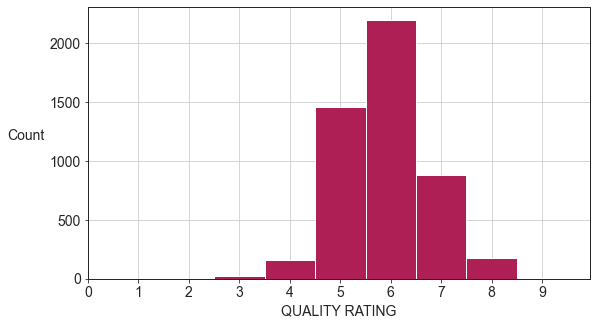

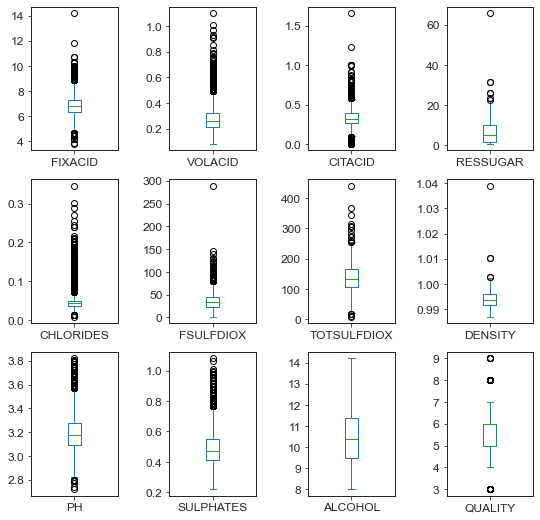

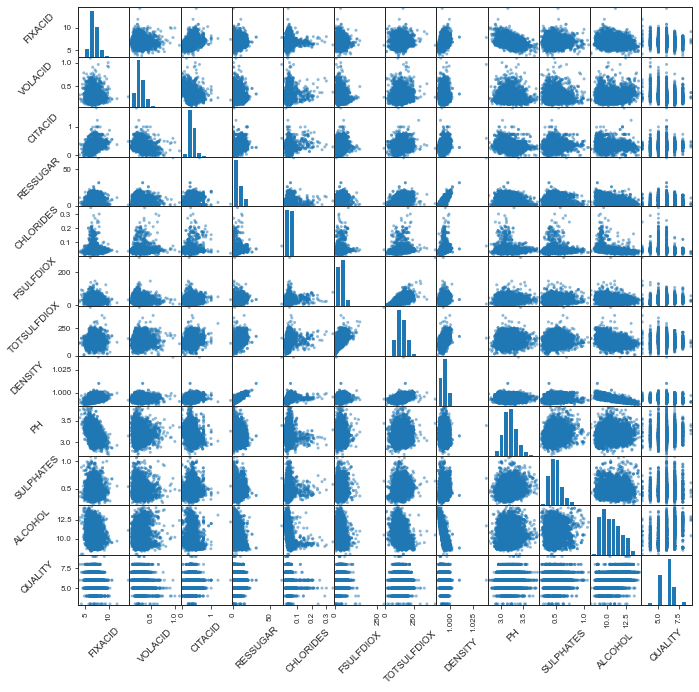

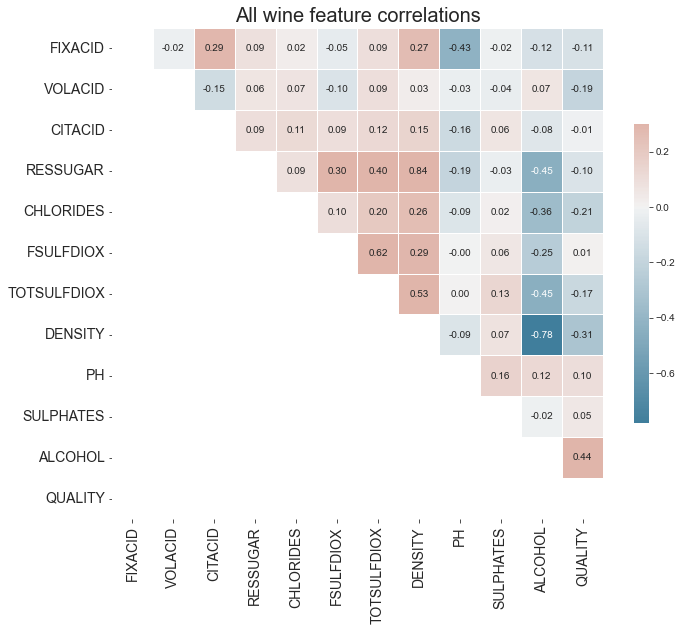

In [626]:
import os.path
from pandas.plotting import scatter_matrix
# b) Load dataset
#filename = 'winequality-red.csv'
filename = 'winequality-white.csv'
print(filename)
names = ['FIXACID', 'VOLACID', 'CITACID', 'RESSUGAR', 'CHLORIDES', 'FSULFDIOX',
'TOTSULFDIOX', 'DENSITY', 'PH', 'SULPHATES','ALCOHOL','QUALITY']
directory='_Practice outside class'
dataset = read_csv(os.path.join('..',directory,filename), header=0, sep=';',names=names,na_values='.')

# 2. Summarize Data
# a) Descriptive statistics
# shape
display(dataset.shape)
# types
print(dataset.dtypes)
# head
print()
display('First 5 rows of dataset:')
display(dataset.head())
# descriptions
#quality distribution

print()
print('Summary statistics for each attribute:')
set_option('precision', 1)
set_option('display.float_format', lambda x: '%.5f' % x)
display(dataset.describe())
# correlation
print()
print('Correlations of the dataset:')
set_option('precision', 2)
display(dataset.corr(method='pearson'))

print()
print('Count of quality by quality category:')
print(dataset.groupby('QUALITY').size())

matplotlib.rcParams["axes.linewidth"] = 1 #formerly 3
matplotlib.rcParams["lines.linewidth"] = 1 #formerly 3
matplotlib.rcParams["figure.figsize"] = (9,5)
# This color map will not work for Pandas hist
# It may work for other graphs
matplotlib.rcParams['image.cmap']='Spectral'
bins = np.arange(0.5,dataset['QUALITY'].max() + 1.5,1)
dataset.hist(column='QUALITY', bins=bins, color=['#AE1F56'])
plt.xticks(range(dataset['QUALITY'].max()+1),fontsize=14)
plt.yticks(fontsize=14)
plt.title('')
plt.xlabel('QUALITY RATING',fontsize=14)
plt.ylabel('Count',fontsize=14,rotation=0,labelpad=24)
plt.show()

# alternate way of plotting the histogram of the data
# dataset['QUALITY'].value_counts().sort_index().plot(
#                kind='bar', stacked=True, width=1, figsize=(
#                    9, 5), rot=0, cmap='Spectral', grid=True, fontsize=14)
# plt.xlabel("QUALITY RATING", labelpad=14,fontsize=16,rotation=0)
# plt.ylabel("Count", labelpad=70, 
#                       fontsize=16,rotation=0)
# plt.show()
matplotlib.rcParams["figure.figsize"] = (9,9)
dataset.plot(
kind='box', subplots=True, layout=(3,4), sharex=False, sharey=False, fontsize=12)
plt.subplots_adjust(wspace=0.6,hspace=0.2)
plt.show()

matplotlib.rcParams["figure.figsize"] = (11,11)
# scatter plot matrix
#scatter_matrix(dataset)
scatter_matrix = scatter_matrix(
    dataset,
    figsize  = [11, 11]
    
)
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 45, labelpad=20)
plt.show()


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr=dataset.corr()
# Generate a mask for the lower triangle
mask = np.tril(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f",
vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('All wine feature correlations',fontsize=20)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.show()


The most noticeable aspect of the data is the imbalance in quality ratings. Very good and poor wines are rare, comprising only 3.7% of the white wine sample. Wines on either extreme of the quality spectrum are the ones that are of most interest, but they are also the hardest for machine learning algorithms to classify. 

The correlations between the individual features of this dataset and quality are not strong, but in most cases are rather subtle. Alcohol levels moderately correlate with quality. Alcohol reduces liquid density; thus, these two are negatively correlated. Sugar increases density; thus, these two are positively correlated. 

The box plots show a fair amount of spread among the individual feature values. This may indicate that models will be able to distinguish and separate clusters of features in the feature space, which may assist in classifying the various gradations of wines.

## Prepare data by separating the training and validation (test) datasets.<br>
An 80-20 train-test split was used.

In [532]:
array = dataset.values
X = array[:,0:11]
Y = array[:,11]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
    test_size=validation_size, random_state=seed, stratify=Y)

## Do an analysis of relative feature importance.<br>
Knowledge of feature importance can be helpful in deciding whether to use all or some of the features in the model itself. The ability to elide certain features can improve the efficiency of the program and perhaps even the classification skill of the model.

Feature: FIXACID / Score: 0.067
Feature: VOLACID / Score: 0.126
Feature: CITACID / Score: 0.056
Feature: RESSUGAR / Score: 0.062
Feature: CHLORIDES / Score: 0.067
Feature: FSULFDIOX / Score: 0.110
Feature: TOTSULFDIOX / Score: 0.070
Feature: DENSITY / Score: 0.069
Feature: PH / Score: 0.076
Feature: SULPHATES / Score: 0.062
Feature: ALCOHOL / Score: 0.235


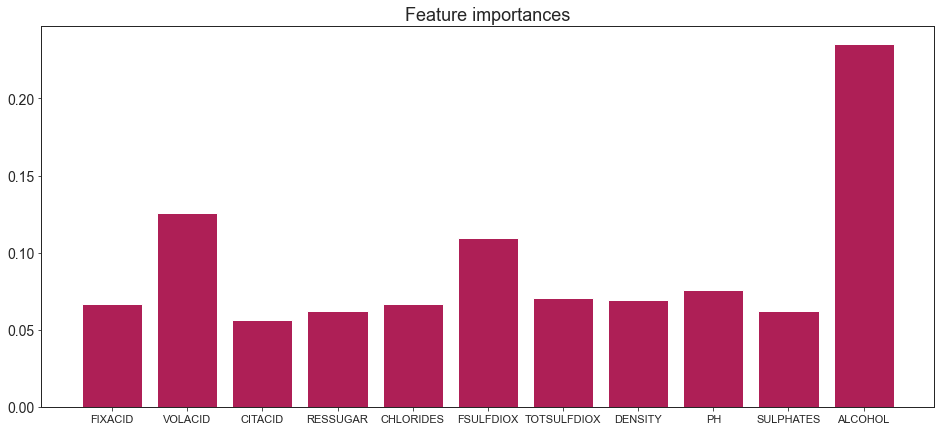

In [533]:
def build_tree(tree_list):
    """
    Returns a dictionary from a 2d list comprised of key-value pairs. The first
    element of each list becomes the dictionary key, and the second element of
    the list becomes the dictionary's value.

    Parameter tree_list: a list comprised of key-value pairs. 
    Precondition: tree_list must be a list comprised of unique key-value pairs.
    """
    d = {i[0]:i[1] for i in tree_list}
    return d

features = ['FIXACID', 'VOLACID', 'CITACID', 'RESSUGAR', 'CHLORIDES', 'FSULFDIOX',
'TOTSULFDIOX', 'DENSITY', 'PH', 'SULPHATES','ALCOHOL']
# define feature importance as corrolary to Cortez (primary paper author's) work
# get importance
model = DecisionTreeRegressor()
model.fit(X,Y)
importance=model.feature_importances_

# summarize feature importance
tree=[]

#print(tree)
for i,v in enumerate(importance):
    tree.append([str(features[i])]+[float(v)])
    
tree_dict=build_tree(tree)
#print(tree_dict)   

for k,v in tree_dict.items():
    print('Feature:',k,'/ Score: %.3f' % float(v))
matplotlib.rcParams["figure.figsize"] = (16,7)
# plot feature importance
names = list(tree_dict.keys())
values = list(tree_dict.values())
plt.bar(range(len(tree_dict)), values, tick_label=names, color=['#AE1F56'])
plt.xticks(fontsize=11)
plt.yticks(fontsize=14)
plt.title('Feature importances',fontsize=18)
plt.show()

While alcohol stands out among the rest of the features, probably due to its correlation with quality, there are no strong groupings of useful versus not useful features. It is not immediately clear which, if any, features, would not be relevant to a prospective machine learning model. (I note that these rankings are different than those arrived at by the study authors.)

## Use RFE (Recursive Feature Elimination) to help determine whether some features can be sacrificed.<br>
The decision of how many features should be selected is left to the programmer. I chose eight (8).

In [534]:
model = DecisionTreeClassifier()
rfe = RFE(model, n_features_to_select=8)
fit = rfe.fit(X, Y)
print('Recursive feature elimination:')
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
count_arr = np.count_nonzero(fit.support_)
print("Number of features that are True:",count_arr)
print("Feature Ranking: %s" % fit.ranking_)

Recursive feature elimination:
Num Features: 8
Selected Features: [False  True False  True  True  True  True  True  True False  True]
Number of features that are True: 8
Feature Ranking: [2 1 3 1 1 1 1 1 1 4 1]


RFE appears to rank the features similarly to the way in which the bar graph above does.

## Use the cross_val_score to evaluate the CART (Classification and Regression Decision Tree) model on all possible number of features.

>1 0.495 (0.020)
>2 0.561 (0.024)
>3 0.602 (0.018)
>4 0.610 (0.021)
>5 0.619 (0.020)
>6 0.617 (0.019)
>7 0.624 (0.020)
>8 0.624 (0.025)
>9 0.622 (0.025)
>10 0.626 (0.025)
>11 0.626 (0.023)


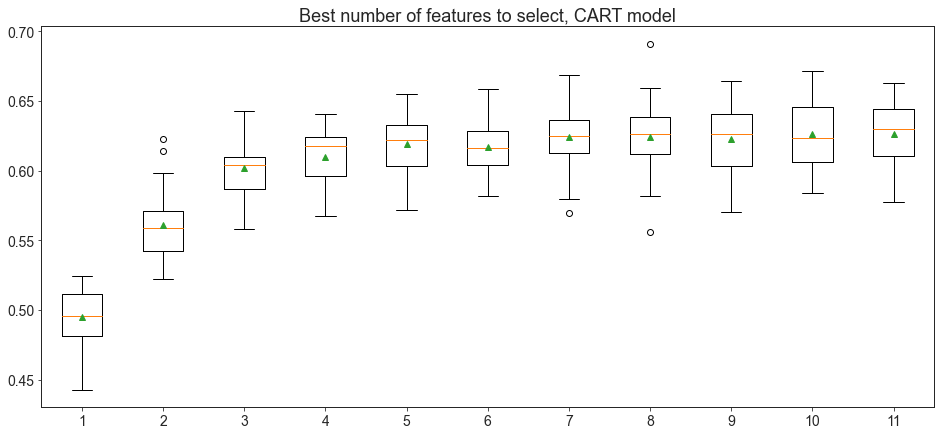

In [535]:
# evaluate best number of features to select
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1,
    error_score='raise')
    return scores

# define number of features to evaluate
num_features = [i+1 for i in range(X.shape[1])]
# enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('SelectKBest',fs), ('CART', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X, Y)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results,labels=num_features,showmeans=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Best number of features to select, CART model',fontsize=18)
plt.show()

A consensus seems to be forming that between 8 and 11 features selected will work well, but other tools remain available to let the model decide.

## Obtain a baseline metric of which models perform best.

In [536]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

# Evaluate algorithms: Linear Regression looked good, at first
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART Regressor', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
print('Evaluation of Mean Square Error results of different models')
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(
  model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

Evaluation of Mean Square Error results of different models
LR: -0.565453 (0.034271)
LASSO: -0.753130 (0.031062)
EN: -0.746561 (0.030467)
KNN: -0.680302 (0.030481)
CART Regressor: -0.767468 (0.084180)
SVR: -0.678505 (0.026787)


## Plot the results of model performance on a box plot chart.

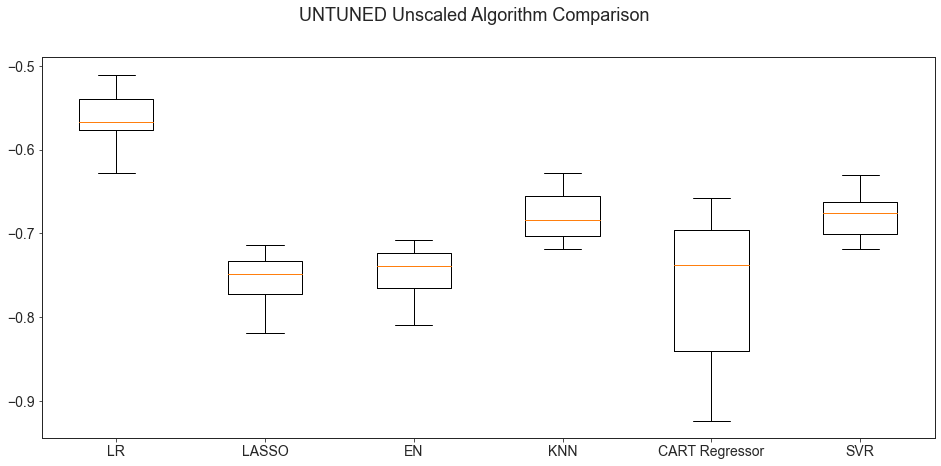

In [537]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('UNTUNED Unscaled Algorithm Comparison',fontsize=18)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Linear Regression outperformed SVR, which is the reverse of what the study authors concluded. However, the data in this model has neither been scaled nor tuned. We can refine these performance results by scaling and tuning the data prior to running it through various models. Once this has been done, a different result, closer to what the study authors found, might be obtained.

## Refine the model comparison by introducing the Standard Scaler into a pipeline for each of the same models. Produce REC (Regression Error Characteristic) curves to compare the models more precisely. The higher the Area Under Curve (AUC) score is, the better the model performs.


Evaluation of Mean Square Error results of different SCALED models
LR: -0.566108 (0.029539)
SVR: -0.480627 (0.026725)
LASSO: -0.784002 (0.001503)
EN: -0.784002 (0.001503)
KNN: -0.525375 (0.034763)
CART Regressor: -0.751580 (0.068522)


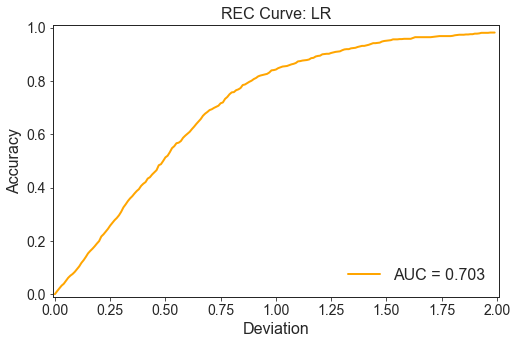

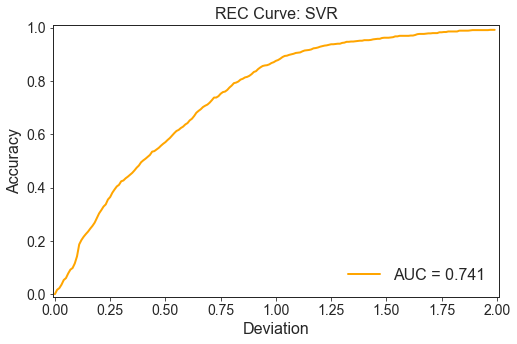

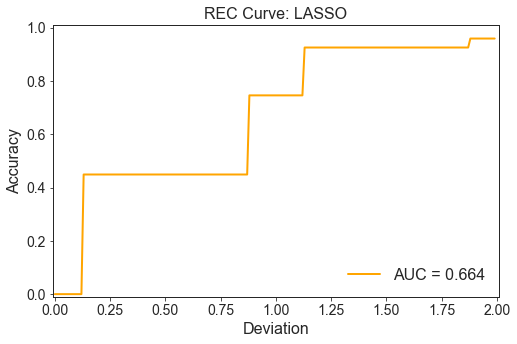

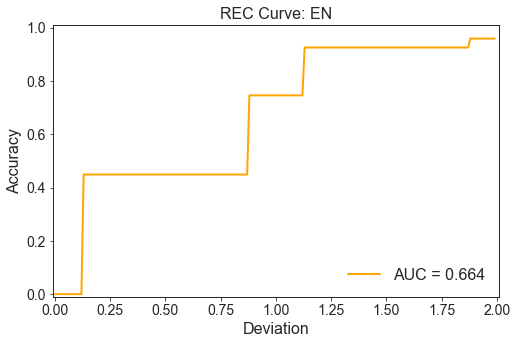

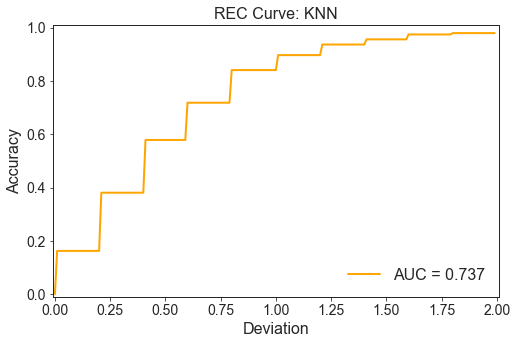

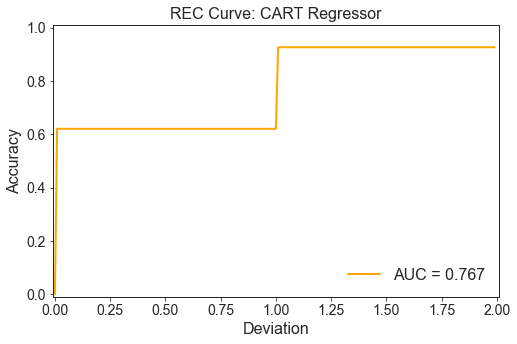

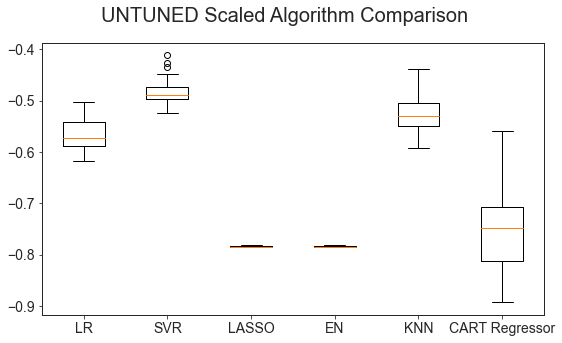

In [631]:
# Evaluate algorithms with scalar standardization: SVR looked good
# Standardize the dataset
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR',
LinearRegression())])))
pipelines.append(('SVR', Pipeline(
[('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('LASSO', Pipeline([(
'Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('EN', Pipeline(
[('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('KNN', Pipeline(
[('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('CART Regressor', Pipeline(
[('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))

results = []
names = []
print()
print('Evaluation of Mean Square Error results of different SCALED models')
for name, model in pipelines:
    #kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
    cv_results = cross_val_score(
    model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    # plot REC curve
    scaler = StandardScaler().fit(X_train)
    rescaledXt = scaler.transform(X_train)
    rescaledXv = scaler.transform(X_validation)
    model.fit(rescaledXt, Y_train)
    predictions = model.predict(rescaledXv)
    myREC = RegressionErrorCharacteristic(Y_validation, predictions, curve=False)
    ##myREC.plot_rec(mtype=name, longxlim=False)
    myREC.plot_rec(mtype=name, longxlim=True) 

plt.show()
fig = plt.figure(figsize=[9,5])
fig.suptitle('UNTUNED Scaled Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Note that we have not yet applied the function to transform the predicted values into discrete categorical values. Therefore, regression models SVR (Support Vector Regression) and LR (Linear Regression) show up in the REC curves as curves, rather than in the shape of a stairway. One might easily change these settings later on, but retaining the curves for the moment for these regression models allows a better comparison with Fig.3 from the study author's [paper](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377).
  
The box plots above show that the SVR outperforms LR, just as the study authors showed in 2009.

## Before studying classification models in greater detail, however, let's fine-tune the SVR model the best that we can, to be sure that we are giving it a fair chance to demonstrate what it can do.
First, let's rerun the SVR model above. This time, we will apply the function to transform the predicted values into discrete categorical values, which we will scale. The discrete values will allow the use of the eval_final function, which provides a more detailed report on performance of the SVR model, including a confusion matrix, which can only be provided from categorical input. We will not worry yet about cross validation or including the scale into a pipeline, since we only want a baseline performance result.


Evaluation of UNTUNED Scaled SVR model
Mean squared error of UNTUNED Scaled SVR predictions against Y validation
0.45912617502007985
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 4 out of 33 : 12.1%
number of 5s accurately predicted is 168 out of 291 : 57.7%
number of 6s accurately predicted is 317 out of 440 : 72.0%
number of 7s accurately predicted is 70 out of 176 : 39.8%
number of 8s accurately predicted is 0 out of 35 : 0.0%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 57.0%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.323750
MAD: 0.511602
[[  0   0   1   3   0   0   0]
 [  0   4  19   9   1   0   0]
 [  0   4 168 115   4   0   0]
 [  0   1  75 317  47   0   0]
 [  0   0   2 104  70   0   0]
 [  0   0   0  15  20   0   0]
 [  0   0   0   0   1   0   0]]
Accuracy_score based on rounding: 0.5704081632653061
Precision_score based on rounding: 0.5439262847366336
        

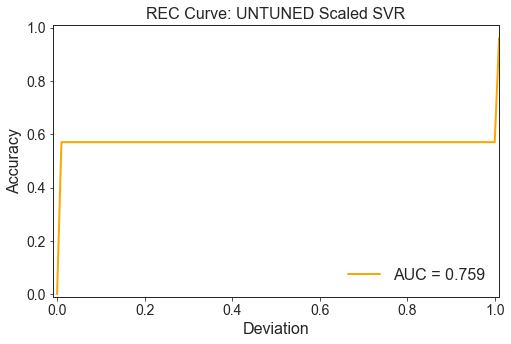

In [539]:
# prepare the model by rescaling training and validation data
# run untuned SVR model on the training data and evaluate against the
# validation data
print()
print('Evaluation of UNTUNED Scaled SVR model')
model=SVR()
scaler = StandardScaler().fit(X_train)
rescaledXt = scaler.transform(X_train)
rescaledXv = scaler.transform(X_validation)
model.fit(rescaledXt, Y_train)
predictions = model.predict(rescaledXv)
print(
'Mean squared error of UNTUNED Scaled SVR predictions against Y validation')
print(mean_squared_error(Y_validation, predictions))
eval_final(rescaledXv, mtype='UNTUNED Scaled SVR', curve=False, tolerance=0.50)

Now that we can see this expanded report that the eval_final() function provides, it becomes clear that no single metric can tell the full story of the performance of a model. Area under the REC curve can give us a baseline of information, but there are equally important metrics the above report provides. All the metrics provide information, but the most contextually important, in my opinion, are weighted recall, Kappa, Mean Average Deviation (MAD), and, critical for fine-tuning, the recall of quality level-4 (a poorer wine), and the recall of quality level-8 (an excellent wine). These last two may be the most important of all, since they distinguish a model by its ability to classify what is known as 'the positive class,' in other words, the class of values (poor, excellent) in which we are most interested. Any model should be able to perform reasonably well on the middle classes of wines, since they are the vast majority of the wines in the database and pure chance would favor the model as having 'guessed' correctly. The extremes of the wine spectrum are the most challenging, and therefore reveal the 'true skill' of any model.

We may begin a fair comparison by assembling the results of the SVR assessment into a Pandas dataframe. For good measurement, we should include these metrics from the original 2009 paper as well.

In [540]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study'],
        'Model':['SVR','SVR'],
        'Characteristics':['feature selection; tolerances','Scaled'],
        'weighted recall':['64.6%','57.0%'],
        'Kappa':['43.9','32.4'],
        'MAD':['.45','.51'],
        'recall-4':['11.7%','12.1%'],
        'recall-8':['33.5%','0.0%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa,MAD,recall-4,recall-8
0,2009 study,SVR,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,SVR,Scaled,57.0%,32.4,.51,12.1%,0.0%


So far, we have been able to approximate the results of the 2009 study in the SVR model, but since original code algorithms from 2009 are not available, we will not be able to duplicate the 2009 result. Nevertheless, the Pandas dataframe provides a baseline of results, which we can supplement as we test additional models.

## Tuning the hyperparameters of SVR
When we run the SVR model as if it were a categorical algorithm, we find that its performance in its REC curve appears to be just as good as for the CART model. Can the SVR model be improved even further by tuning its hyperparameters? The choice of the range of parameters on which to search was partly dictated by considerations of processing time. Searches of too wide a range of values will take much longer to complete, and the gains in performance would be marginal.

In [541]:
# Parameters for tuning
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
scorer = make_scorer(mean_squared_error, greater_is_better=False)
#parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 10, 100, 1000, 10000]}]
#parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [5]}]
parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 5, 10]}]

print("Tuning hyper-parameters...")
grid = GridSearchCV(SVR(epsilon = 0.01), parameters, cv=kfold, scoring=scorer)
grid_result = grid.fit(rescaledXt, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Checking the score for all parameters
print('Grid scores on training set:')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))


Tuning hyper-parameters...
Best: -0.457041 using {'C': 1, 'gamma': 0.6, 'kernel': 'rbf'}
Grid scores on training set:
-0.715 (+/-0.064) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
-0.573 (+/-0.049) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-0.515 (+/-0.042) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-0.488 (+/-0.054) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
-0.473 (+/-0.055) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
-0.458 (+/-0.053) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
-0.457 (+/-0.054) for {'C': 1, 'gamma': 0.6, 'kernel': 'rbf'}
-0.463 (+/-0.059) for {'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}
-0.596 (+/-0.050) for {'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}
-0.552 (+/-0.049) for {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
-0.505 (+/-0.047) for {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
-0.490 (+/-0.067) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
-0.489 (+/-0.064) for {'C': 5, 'gamma': 0.2, 'kernel': 'rbf'}
-0.476 (+/-0.064) for {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
-0

## Check optimal number of features again.
As an interim step, we want to ensure that the optimal number of features to evaluate has remained constant even with tuning the SVR model. Plug the best hyperparameter values obtained above into the SVR model. Evaluate with a repeated stratified kfold, thus ensuring a statistically valid mean comparison value. Use the SelectKBest function for an automatic selection of an optimal number of features to select.

num_features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
>1 -0.681 (0.026)
>2 -0.681 (0.026)
>3 -0.588 (0.023)
>4 -0.621 (0.026)
>5 -0.620 (0.026)
>6 -0.563 (0.035)
>7 -0.541 (0.023)
>8 -0.536 (0.022)
>9 -0.536 (0.022)
>10 -0.536 (0.022)
>11 -0.536 (0.022)


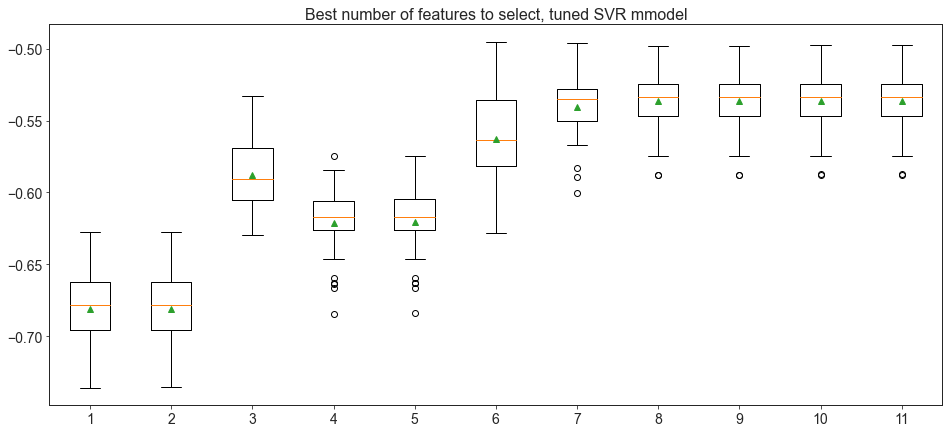

In [542]:
from numpy import mean
from numpy import std
# Finalize model with the tuned parameters: use all training data and confirm
# using validation dataset
if 'white' in filename:
    svrmodel=SVR(C=1.0,gamma=0.6,kernel='rbf')
else:
    svrmodel=SVR(C=1.0,gamma=0.2,kernel='rbf')

###
#calculate number of best features
# evaluate best number of features to select
# evaluate a given model using cross-validation
# Note here how tuned parameters are employed simultaneously with feature selection
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(
    model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define number of features to evaluate
num_features = [i+1 for i in range(X.shape[1])]
print('num_features:',num_features)
# enumerate each number of features
results = list()

for k in num_features:
    # create pipeline
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('SelectKBest',fs), ('SVR', svrmodel)])
    # evaluate the model
    scores = evaluate_model(pipeline, X, Y)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

# plot model performance for comparison
#print(results)
plt.title('Best number of features to select, tuned SVR mmodel',fontsize=16)
plt.boxplot(results, labels=num_features, showmeans=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


We find from the box plots above that the optimal number of features has remained steady, despite some variation in the lower ranges. We want the optimal number, so therefore the fact that three (3) features is apparently more optimal than five (5) features is of little consequence. We will be selecting seven (7) or more features.

### Now we can submit a fine-tuned SVR model that we may then compare with the results of the CART Regressor. 
The following code combines Principal Component Analysis with SelectKBest to supply an optimal number of features to select. We also scale the training set using the standard scaler. The scaling is performed within a pipeline on each kfold. This is done to prevent data leakage, an undue bias that would otherwise be introduced by scaling the entire training dataset prior to fitting of the model. Finally, the tuned SVR model is fit to each kfold, using the optimal hyperparameters identified in the prior step.


Report on accuracy of TUNED scaled SVR with best features*
*includes PCA: Principal Component Analysis
Cross Validation MSE: -0.480627 (0.026725)
Mean squared error of TUNED Scaled SVR predictions against Y validation
0.43480597627614426
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 0 out of 33 : 0.0%
number of 5s accurately predicted is 159 out of 291 : 54.6%
number of 6s accurately predicted is 390 out of 440 : 88.6%
number of 7s accurately predicted is 98 out of 176 : 55.7%
number of 8s accurately predicted is 2 out of 35 : 5.7%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 66.2%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.454639
MAD: 0.447678
[[  0   0   0   4   0   0   0]
 [  0   0   8  25   0   0   0]
 [  0   0 159 131   1   0   0]
 [  0   0  33 390  17   0   0]
 [  0   0   0  77  98   1   0]
 [  0   0   0  18  15   2   0]
 [  0   0   0   1   0   0   0]]
Accuracy_sc

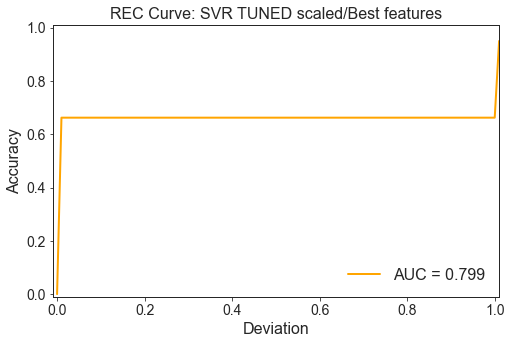

In [543]:
#10 for red
#9 for white
if 'white' in filename:
    n_components=9
else:
    n_components=10
###

print()
print('Report on accuracy of TUNED scaled SVR with best features*')
print('*includes PCA: Principal Component Analysis')
features = []
features.append(('PCA',PCA(n_components=n_components)))
features.append((
'select_best', SelectKBest(score_func=f_classif, k=n_components)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('SVR', Pipeline([('Scaler', StandardScaler()),(
'SVR', svrmodel)])))
model = Pipeline(estimators)
# evaluate pipeline
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print("Cross Validation MSE: %f (%f)" % (cv_results.mean(), cv_results.std()))

model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
print('Mean squared error of TUNED Scaled SVR predictions against Y validation')
print(mean_squared_error(Y_validation, predictions))
eval_final(X_validation, mtype='SVR TUNED scaled/Best features', curve=False)

Tuning and scaling the SVR model within a pipeline yields an AUC (area under the REC curve) of 0.799, higher than the CART Regressor and the previous untuned SVR model. We can add this result to our collection.

In [645]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study'],
        'Model':['SVR','SVR','SVR'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled'],
        'weighted recall':['64.6%','57.0%','66.2%'],
        'Kappa(%)':['43.9','32.4','45.5'],
        'MAD':['.45','.51','.45'],
        'recall-4':['11.7%','12.1%','0.0%'],
        'recall-8':['33.5%','0.0%','5.7%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,SVR,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,SVR,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,SVR,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%


We find tuning and scaling the SVR model has caused an improvement in several of the metrics but this has occurred at the expense of recall-4 and recall-8, a common phenomenon. The SVR from the original 2009 study still dominates our beginner's attempts at classification.

## Take a look at K-Nearest Neighbors.
KNN ranked second in our initial box-plot comparison of model skill. It should not be overlooked. Perhaps tuning the KNN model can yield satisfactory results.

Experiment with KNN
Best: -0.508760 using {'n_neighbors': 9}
-0.627703 (0.047772) with: {'n_neighbors': 1}
-0.543603 (0.034763) with: {'n_neighbors': 3}
-0.524681 (0.034683) with: {'n_neighbors': 5}
-0.513568 (0.032802) with: {'n_neighbors': 7}
-0.508760 (0.029898) with: {'n_neighbors': 9}
-0.510344 (0.026234) with: {'n_neighbors': 11}
-0.509739 (0.024398) with: {'n_neighbors': 13}
-0.510729 (0.025188) with: {'n_neighbors': 15}
-0.510191 (0.024701) with: {'n_neighbors': 17}
-0.510791 (0.025468) with: {'n_neighbors': 19}
-0.512004 (0.025044) with: {'n_neighbors': 21}
Mean squared error of predictions against Y validation
0.49011085915847824
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 0 out of 33 : 0.0%
number of 5s accurately predicted is 155 out of 291 : 53.3%
number of 6s accurately predicted is 307 out of 440 : 69.8%
number of 7s accurately predicted is 85 out of 176 : 48.3%
number of 8s accurately predicted is 2 out of 3

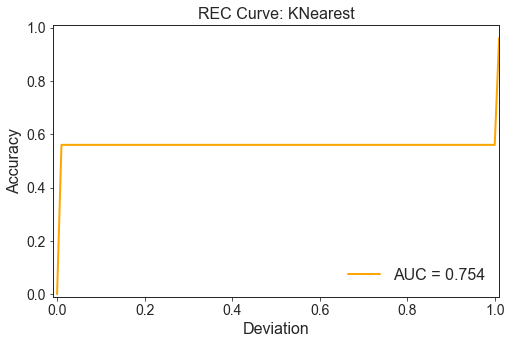

In [545]:
# KNN experiment
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
#kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
grid = GridSearchCV(
estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print('Experiment with KNN')
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

estimators=[]
K = KNeighborsRegressor(
n_neighbors=grid_result.best_params_['n_neighbors'])
estimators.append(('KNeighborsRegressor', Pipeline([(
'Scaler', StandardScaler()),('KNeighbors', K)])))
model = Pipeline(estimators)
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
print('Mean squared error of predictions against Y validation')
print(mean_squared_error(Y_validation, predictions))
eval_final(X_validation, mtype='KNearest', curve=False)

KNN has not scored better than our previous attempts, even after tuning and scaling. It may be that KNN is poorly suited for exposing the structure of this dataset. Nevertheless, let's add KNN to our collection.

In [646]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study'],
        'Model':['SVR','SVR','SVR','KNN'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1'],
        'MAD':['.45','.51','.45','.53'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,SVR,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,SVR,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,SVR,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,KNN,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%


## Test a number of different classification models together.
If we are to exceed the model results of the original 2009 study, we will need to do better. A good first step is to compare a number of different classification models simultaneously, this time with scaling, to see which hold the most promise.


Algorithm: Negative mean squared error (Standard deviation)
LR- 
 unweighted: -0.655948 (0.040954)
LR- 
 weighted: -1.344454 (0.123582)
LDA: -0.661307 (0.049152)
KNN: -0.700440 (0.042612)
CART: -0.766554 (0.070999)
Bagged 
 Tree: -0.475657 (0.034373)
Random 
 Forest: -0.470640 (0.040476)
Extra 
 Trees: -0.467742 (0.038848)
Gaussian 
 NB: -0.956860 (0.068648)
SVC 
 class- 
 unweighted: -0.591286 (0.034179)
SVC 
 class- 
 weighted: -1.089496 (0.087025)


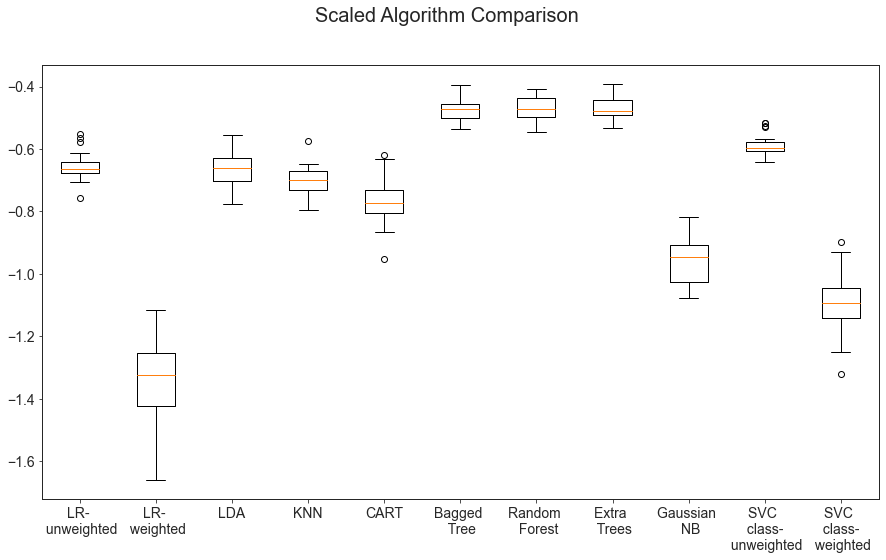

In [691]:
pipelines = []
pipelines.append(('LR- \n unweighted', Pipeline([('Scaler', StandardScaler()),
('LR',LogisticRegression(solver='liblinear', multi_class='ovr'))])))
pipelines.append(('LR- \n weighted', Pipeline([('Scaler', StandardScaler()),
('LR',LogisticRegression(
solver='liblinear',class_weight='balanced',multi_class='ovr'))])))
# "Is multicollinearity in my features a problem?
# It is for interpretation of the feature importances. You can’t rely on the
# model weights to be meaningful when there is high correlation between the
# variables. Credit for affecting the outcome variable might go to just one of
# the correlated features."
pipelines.append(('LDA', Pipeline([('Scaler', StandardScaler()),
('LDA',LinearDiscriminantAnalysis())])))
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()),
('KNN',KNeighborsClassifier())])))
pipelines.append(('CART', Pipeline([('Scaler', StandardScaler()),
('CART',DecisionTreeClassifier())])))
cart = DecisionTreeClassifier()
num_trees=100
pipelines.append(('Bagged \n Tree', Pipeline([('Scaler', StandardScaler()),
('Bagging Classifier',BaggingClassifier(
base_estimator=cart,n_estimators=num_trees,random_state=seed))])))
#max_features=3
pipelines.append(('Random \n Forest', Pipeline([('Scaler', StandardScaler()),
('Random Forest',RandomForestClassifier(
n_estimators=num_trees,max_features=n_components))])))
#max_features=7
pipelines.append(('Extra \n Trees', Pipeline([('Scaler', StandardScaler()),
('ExtraTrees',ExtraTreesClassifier(
n_estimators=num_trees,max_features=n_components))])))
pipelines.append(('Gaussian \n NB', Pipeline([('Scaler', StandardScaler()),
('GNB',GaussianNB())])))
pipelines.append(
('SVC \n class- \n unweighted', Pipeline([('Scaler', StandardScaler()),
('SVC',SVC(gamma='auto'))])))
pipelines.append(('SVC \n class- \n weighted', Pipeline([('Scaler', StandardScaler()),
('SVCw',SVC(gamma='scale',class_weight='balanced'))])))

# evaluate each model above in turn
results = []
names = []
print()
print('Algorithm: Negative mean squared error (Standard deviation)')
for name, model in pipelines:
    #kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold,
    scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# d) Compare Algorithms
fig = plt.figure(figsize=[15,8])
fig.suptitle('Scaled Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


Although this procedure did not provide detailed reports for each model, the box plot above reveals that decision trees (Bagged Tree, Random Forest, and Extra Trees) appear to hold a decided advantage in MSE (mean squared error). They seemed to outperform all of the other classification models. This is **```something that needs to be investigated further```.** It indicates, perhaps, that better machine learning algorithms may be available for the work of classifying these wines of the vinho verde region of Portugal. We will study decision trees more closely, to discover whether a better model can be obtained than the one from the 2009 study. But first...

## Make a report on SVC class-weighted.
This model seemed to perform poorly, but it would be interesting to add this to our collection, for the sake of diversity.


Report on accuracy of Weighted SVC with best features*
*includes PCA
Cross Validation Accuracy: 44.555% (1.956%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 17 out of 33 : 51.5%
number of 5s accurately predicted is 164 out of 291 : 56.4%
number of 6s accurately predicted is 137 out of 440 : 31.1%
number of 7s accurately predicted is 96 out of 176 : 54.5%
number of 8s accurately predicted is 14 out of 35 : 40.0%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 43.7%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.260721
MAD: 0.733673
[[  0   1   1   0   1   1   0]
 [  2  17   8   3   2   1   0]
 [  3  51 164  47  18   8   0]
 [  6  37  92 137 132  32   4]
 [  1   4  10  26  96  39   0]
 [  0   0   0   2  18  14   1]
 [  0   0   0   0   0   1   0]]
Accuracy_score based on rounding: 0.43673469387755104
Precision_score based on rounding: 0.5381622211715766
              precision 

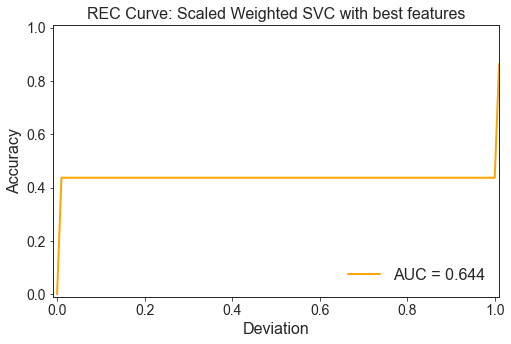

In [548]:
print()
print('Report on accuracy of Weighted SVC with best features*')
print('*includes PCA')
features = []
features.append(('PCA',PCA(n_components=n_components)))
features.append(('RFE',RFE(
estimator=DecisionTreeClassifier(),n_features_to_select=n_components)))
features.append((
'select_best', SelectKBest(score_func=f_classif, k=n_components)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('SVC weighted', Pipeline([('Scaler', StandardScaler()),(
'SVCw', SVC(gamma='auto',class_weight='balanced'))])))
model = Pipeline(estimators)
# evaluate pipeline
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print("Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(
X_validation,mtype='Scaled Weighted SVC with best features',curve=False)

In [647]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1'],
        'MAD':['.45','.51','.45','.53','.73'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,.73,51.5%,40.0%


Even though its weighted recall fell below that of the other models, the decline seemed to be to the benefit of recall-4 and recall-8, which are the best seen so far. It will be interesting to see whether decision trees can improve on recall-4 and recall-8 while also not sacrificing the accuracy of classifying the middle classes.

## Next, let's take a look at scaled CART with best features, a baseline decision tree.

Report on accuracy of Scaled CART with best features*
*includes PCA
Cross Validation Accuracy: 58.491% (2.439%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 6 out of 33 : 18.2%
number of 5s accurately predicted is 195 out of 291 : 67.0%
number of 6s accurately predicted is 296 out of 440 : 67.3%
number of 7s accurately predicted is 110 out of 176 : 62.5%
number of 8s accurately predicted is 16 out of 35 : 45.7%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 63.6%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.462292
MAD: 0.454082
[[  0   0   2   1   1   0   0]
 [  0   6  15  10   2   0   0]
 [  2  12 195  68  12   2   0]
 [  1   5  65 296  67   6   0]
 [  0   3  15  41 110   7   0]
 [  0   1   1  10   7  16   0]
 [  0   0   0   0   0   1   0]]
Accuracy_score based on rounding: 0.6357142857142857
Precision_score based on rounding: 0.6342004153103837
              precision    

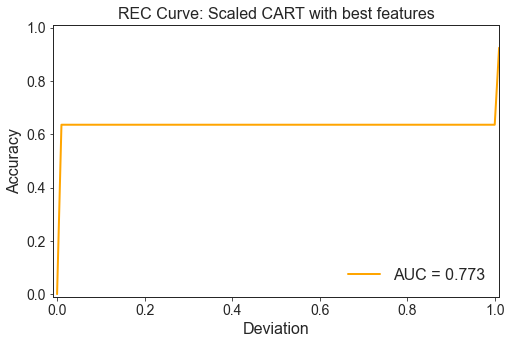

In [550]:
print('Report on accuracy of Scaled CART with best features*')
print('*includes PCA')
features = []
features.append(('PCA',PCA(n_components=n_components)))
features.append(('RFE',RFE(
estimator=DecisionTreeClassifier(),n_features_to_select=n_components)))
features.append((
'select_best', SelectKBest(score_func=f_classif, k=n_components)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('CART', Pipeline([('Scaler', StandardScaler()),(
'CART', DecisionTreeClassifier())])))
model = Pipeline(estimators)
# evaluate pipeline
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print("Cross Validation Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(X_validation,mtype='Scaled CART with best features',curve=False)


## Adding CART to the collection

In [663]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2'],
        'MAD':['.45','.51','.45','.53','73','.45'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%


CART shows itself to be much the equal of SVR from the 2009 study, with a higher KAPPA, equivalent Mean Absolute Deviation, and a recall-4 and recall-8 that is acceptable. Could other decision trees improve upon this result even more?

## Experiment with Balanced Bagged Decision Trees.
Balanced bagged decision trees introduce undersampling of the majority classes in an attempt to improve resolution of the minority. This is but one method of improving the classification skill of imbalanced datasets.

Report on accuracy of Scaled Balanced Bagged (Undersampling Majority) Decision Trees with best features*
*includes PCA
>Train: 3=14, 8=126, Test: 3=2, 8=14
>Train: 6=1583, 5=1050, Test: 6=175, 5=116
Balanced Bagged Decision Trees for Classification with base estimator of Classification and Regression Trees (CART): 100 trees
Cross Validation Accuracy: 32.015% (2.708%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 17 out of 33 : 51.5%
number of 5s accurately predicted is 161 out of 291 : 55.3%
number of 6s accurately predicted is 61 out of 440 : 13.9%
number of 7s accurately predicted is 39 out of 176 : 22.2%
number of 8s accurately predicted is 10 out of 35 : 28.6%
number of 9s accurately predicted is 1 out of 1 : 100.0%
Total percentage predicted correctly: 29.5%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.123911
MAD: 1.106122
[[  0   0   1   1   0   0   2]
 [  2  17   8   1   1   1   3]
 [ 25  51 161  29  14   7   4]


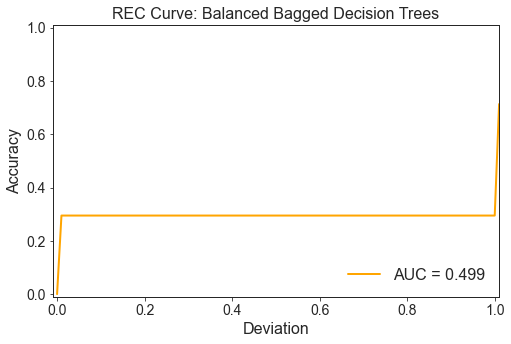

In [552]:
print(
'Report on accuracy of Scaled Balanced Bagged (Undersampling Majority) \
Decision Trees with best features*')
print('*includes PCA')
features = []
features.append(('PCA',PCA(n_components=n_components)))
features.append(('RFE',RFE(
estimator=DecisionTreeClassifier(),n_features_to_select=n_components)))
features.append((
'select_best', SelectKBest(score_func=f_classif, k=n_components)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
cart = DecisionTreeClassifier()
num_trees=100
estimators.append(('Bagged Decision Trees', Pipeline(
[('Scaler', StandardScaler()),(
'Bagged Decision Trees', BalancedBaggingClassifier(
base_estimator=cart,n_estimators=num_trees,random_state=seed))])))
model = Pipeline(estimators)
# evaluate pipeline
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
for train_ix, test_ix in kfold.split(X_train, Y_train):
    # select rows
    train_X, test_X = X_train[train_ix], X_train[test_ix]
    train_y, test_y = Y_train[train_ix], Y_train[test_ix]
    # summarize train and test composition
    train_3, train_8 = len(train_y[train_y==3.0]), len(train_y[train_y==8.0])
    test_3, test_8 = len(test_y[test_y==3.0]), len(test_y[test_y==8.0])
    train_6, train_5 = len(train_y[train_y==6.0]), len(train_y[train_y==5.0])
    test_6, test_5 = len(test_y[test_y==6.0]), len(test_y[test_y==5.0])

    
print(
    '>Train: 3=%d, 8=%d, Test: 3=%d, 8=%d' % (train_3, train_8, test_3, test_8))
print(
    '>Train: 6=%d, 5=%d, Test: 6=%d, 5=%d' % (train_6, train_5, test_6, test_5))

results = cross_val_score(model, X_train, Y_train, cv=kfold)
print(
'Balanced Bagged Decision Trees for Classification with base estimator of ' \
'Classification and Regression Trees (CART): 100 trees')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='Balanced Bagged Decision Trees',curve=False)


The balanced bagging result has the best recall-4 of any model thus far, but this improvement has come at the expense of nearly every other metric. Still, we can add this result to the collection.

In [664]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART','Balanced Bagged Decision Trees'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%


Balanced bagged decision trees had very good recall-4 but this came at the expense of the middle range.

## Let's try bagged decision trees without the refinement of balancing with undersampling of the majority.

Report on accuracy of Scaled Bagged Decision Trees with best features*
*includes PCA
>Train: 3=14, 8=126, Test: 3=2, 8=14
Bagged Decision Trees for Classification with base estimator of Classification and Regression Trees (CART): 100 trees
Cross Validation Accuracy: 65.918% (2.257%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 8 out of 33 : 24.2%
number of 5s accurately predicted is 208 out of 291 : 71.5%
number of 6s accurately predicted is 347 out of 440 : 78.9%
number of 7s accurately predicted is 104 out of 176 : 59.1%
number of 8s accurately predicted is 14 out of 35 : 40.0%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 69.5%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.530068
MAD: 0.337755
[[  0   0   1   3   0   0   0]
 [  0   8  19   5   1   0   0]
 [  0   3 208  78   2   0   0]
 [  0   0  60 347  33   0   0]
 [  0   0   5  66 104   1   0]
 [  0   0   0  10  11  14

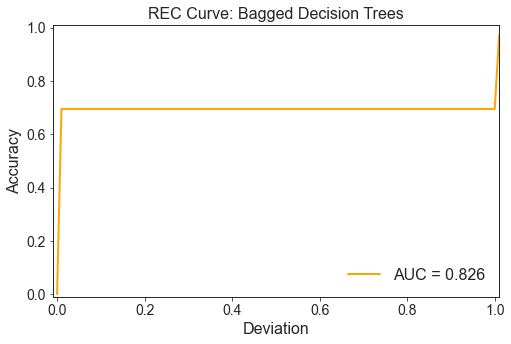

In [554]:
print('Report on accuracy of Scaled Bagged Decision Trees with best features*')
print('*includes PCA')
features = []
features.append(('PCA',PCA(n_components=n_components)))
features.append(('RFE',RFE(
estimator=DecisionTreeClassifier(),n_features_to_select=n_components)))
features.append((
'select_best', SelectKBest(score_func=f_classif, k=n_components)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
cart = DecisionTreeClassifier()
num_trees=100
estimators.append(('Bagged Decision Trees', Pipeline(
[('Scaler', StandardScaler()),(
'Bagged Decision Trees', BaggingClassifier(
base_estimator=cart,n_estimators=num_trees,random_state=seed))])))
model = Pipeline(estimators)
# evaluate pipeline
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
for train_ix, test_ix in kfold.split(X_train, Y_train):
    # select rows
    train_X, test_X = X_train[train_ix], X_train[test_ix]
    train_y, test_y = Y_train[train_ix], Y_train[test_ix]
    # summarize train and test composition
    train_3, train_8 = len(train_y[train_y==3.0]), len(train_y[train_y==8.0])
    test_3, test_8 = len(test_y[test_y==3.0]), len(test_y[test_y==8.0])

print(
    '>Train: 3=%d, 8=%d, Test: 3=%d, 8=%d' % (train_3, train_8, test_3, test_8))
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print(
'Bagged Decision Trees for Classification with base estimator of ' \
'Classification and Regression Trees (CART): 100 trees')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='Bagged Decision Trees',curve=False)


## Adding Bagged Decision Trees to the collection:

In [665]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%


This is much the best result yet, improving on the 2009 study and prior models attempted. The recall-4 leaves a little bit to be desired, but maybe additional models can provide even further enhancement.

## Random Forests enjoy a good reputation among decision trees. Perhaps good results can be obtained from its use:


Report on accuracy of scaled Random Forest Classification with best features*
*includes PCA
Random Forest Classification: 100 trees; splits chosen from random selection of 9 features
Cross Validation Accuracy: 67.024% (2.171%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 7 out of 33 : 21.2%
number of 5s accurately predicted is 206 out of 291 : 70.8%
number of 6s accurately predicted is 356 out of 440 : 80.9%
number of 7s accurately predicted is 105 out of 176 : 59.7%
number of 8s accurately predicted is 13 out of 35 : 37.1%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 70.1%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.537719
MAD: 0.334694
[[  0   0   1   3   0   0   0]
 [  1   7  18   6   1   0   0]
 [  0   3 206  79   3   0   0]
 [  0   1  54 356  29   0   0]
 [  0   0   3  67 105   1   0]
 [  0   0   0  12  10  13   0]
 [  0   0   0   0   1   0   0]]
Accuracy_score bas

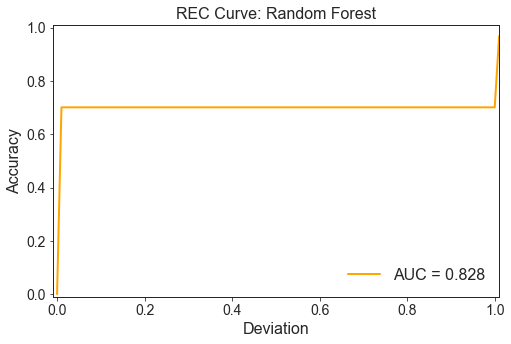

In [556]:
num_trees=100
print()
print(
'Report on accuracy of scaled Random Forest Classification with best features*')
print('*includes PCA')
features = []
features.append(('PCA',PCA(n_components=n_components)))
features.append((
'RFE',RFE(
estimator=DecisionTreeClassifier(),n_features_to_select=n_components)))
features.append(
('select_best', SelectKBest(score_func=f_classif, k=n_components)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
# Try with BalancedRandomForestClassifier to see how undersampling has a
# negative effect on the accuracy
estimators.append((
'Random Forest Classifier', Pipeline([('Scaler', StandardScaler()),(
'Random Forest', RandomForestClassifier(
n_estimators=num_trees, max_features=n_components,
#class_weight='balanced'))])))
class_weight='balanced_subsample'))])))
model = Pipeline(estimators)
# evaluate pipeline
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print('Random Forest Classification: 100 trees; splits chosen ' \
'from random selection of ' + str(n_components) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='Random Forest',curve=False)


## Adding Random Forests to the collection:

In [666]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%


Again, we find that our decision trees are yielding excellent results, surpassing recall-4 and recall-8 of the original study and maintaining equal or better classification accuracy for the midrange.

## Improvements on Random Forests will be incremental, but perhaps even better classification accuracy of the extreme categories of quality will be possible with oversampling techniques.
To begin, let's try using the random oversampling method on the Extra Trees classifier. We will include a graph of how the quality ratings are distributed by pH (x-axis) and by alcohol percent (y-axis). Note that the graphs representing before and after random oversampling will not appear any different. Random oversampling does not create new examples but samples only by adding existing examples to the current example vectors. This is known as sampling "with replacement."

Before oversampling: Counter({6.0: 1758, 5.0: 1166, 7.0: 704, 8.0: 140, 4.0: 130, 3.0: 16, 9.0: 4})


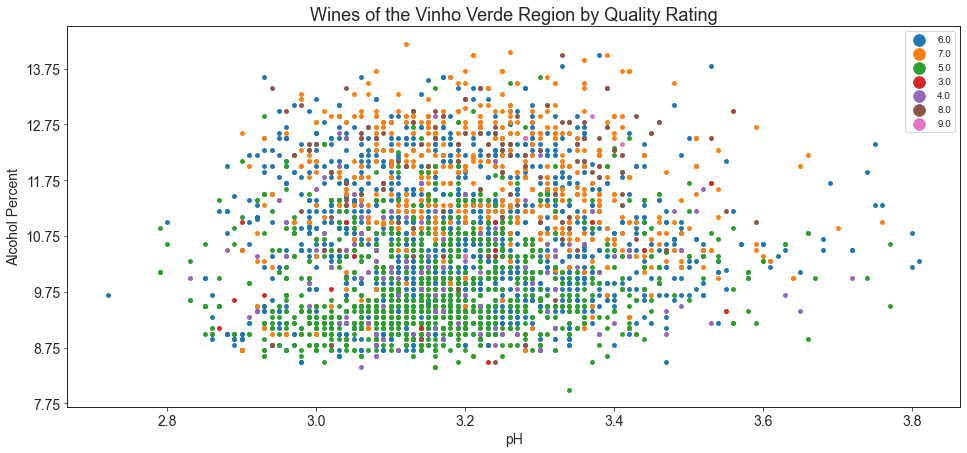

In [605]:
names = ['FIXACID', 'VOLACID', 'CITACID', 'RESSUGAR', 'CHLORIDES', 'FSULFDIOX',
'TOTSULFDIOX', 'DENSITY', 'PH', 'SULPHATES','ALCOHOL','QUALITY']

counter=Counter(Y_train)
print('Before oversampling:',counter)

# scatter plot of examples by class label: pH (8) x Alcohol (10)
# Both pH and Alcohol are correlated with Quality

for label, _ in counter.items():
    # row_ix returns an array containing all the row numbers for a given label (color)
    row_ix = where(Y_train == label)[0]
    plt.scatter(
    X_train[row_ix, 8], X_train[row_ix, 10], label=str(label), alpha=1, s=15)
plt.legend(markerscale=3, fontsize=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Wines of the Vinho Verde Region by Quality Rating", fontsize=18)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.yticks(np.arange(7.75, 14.25, 1.0))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

After Random Oversampling: Counter({6.0: 1758, 7.0: 1758, 5.0: 1758, 3.0: 1758, 4.0: 1758, 8.0: 1758, 9.0: 1758})
1758


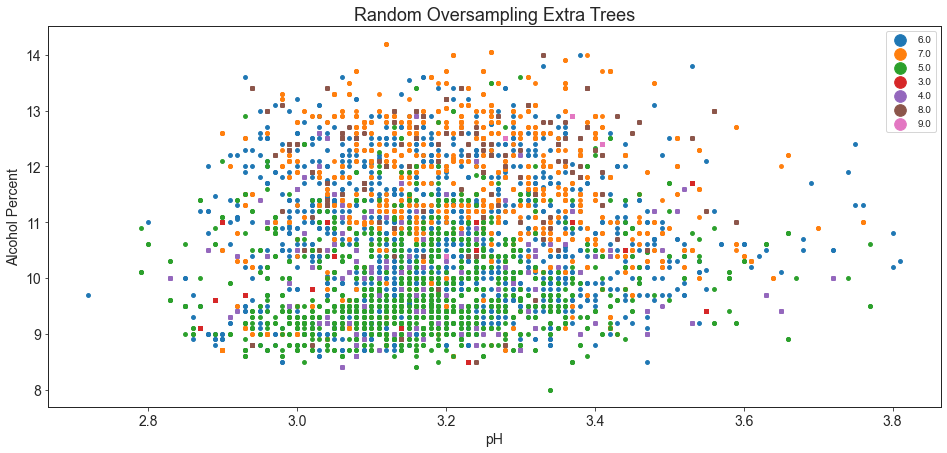

In [606]:
oversample = RandomOverSampler()
X_trainov, Y_trainov = oversample.fit_resample(X_train, Y_train)
#print(Y_trainov)
counter=Counter(Y_trainov)
print('After Random Oversampling:',counter)
# scatter plot of examples by class label

for label, _ in counter.items():
    # row_ix returns an array containing all the row numbers for a given label (color)
    row_ix = where(Y_trainov == label)[0]
    plt.scatter(
    X_trainov[row_ix, 8], X_trainov[row_ix, 10], label=str(label), alpha=1, s=15)
print(len(row_ix))
plt.title('Random Oversampling Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Here are the results for random oversampling with Extra Trees.

Report on accuracy of scaled Extra Trees Classification with Random  Oversampling
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 67.237% (2.223%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 7 out of 33 : 21.2%
number of 5s accurately predicted is 203 out of 291 : 69.8%
number of 6s accurately predicted is 363 out of 440 : 82.5%
number of 7s accurately predicted is 102 out of 176 : 58.0%
number of 8s accurately predicted is 15 out of 35 : 42.9%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 70.4%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.540904
MAD: 0.330612
[[  0   0   1   3   0   0   0]
 [  1   7  17   7   1   0   0]
 [  0   4 203  83   1   0   0]
 [  0   1  49 363  27   0   0]
 [  0   0   3  69 102   2   0]
 [  0   0   0  12   8  15   0]
 [  0   0   0   0   1   0   0]]
Accuracy_score based on roundin

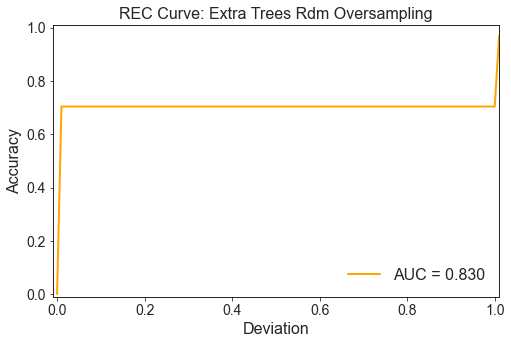

In [560]:
num_trees=100
max_features=8

print(
'Report on accuracy of scaled Extra Trees Classification with Random \
 Oversampling')
imbPipeline=make_pipeline(
StandardScaler(),RandomOverSampler(),ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features))

# evaluate pipeline
# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We don't want to oversample twice!
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline, X_train, Y_train, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline.fit(X_train,Y_train)
predictions = imbPipeline.predict(X_validation)
eval_final(X_validation, mtype='Extra Trees Rdm Oversampling',curve=False)

## Adding random oversampling with Extra Trees to the collection:

In [667]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees'],
        'Characteristics':['feature selection; tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%']
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,feature selection; tolerances,64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


Although the gains are not as significant, the Extra Trees model with random oversampling achieved improvements in nearly every metric. Notably, the recall-8 increased to 42.9%.

## Other oversampling methods exist. BorderlineSMOTE (Synthetic Minority Oversampling) is an algorithm that adds synthetic examples to the dataset that improve the resolving power of the classification.

After BorderlineSMOTE: Counter({6.0: 1758, 7.0: 1758, 5.0: 1758, 3.0: 1758, 4.0: 1758, 8.0: 1758, 9.0: 4})


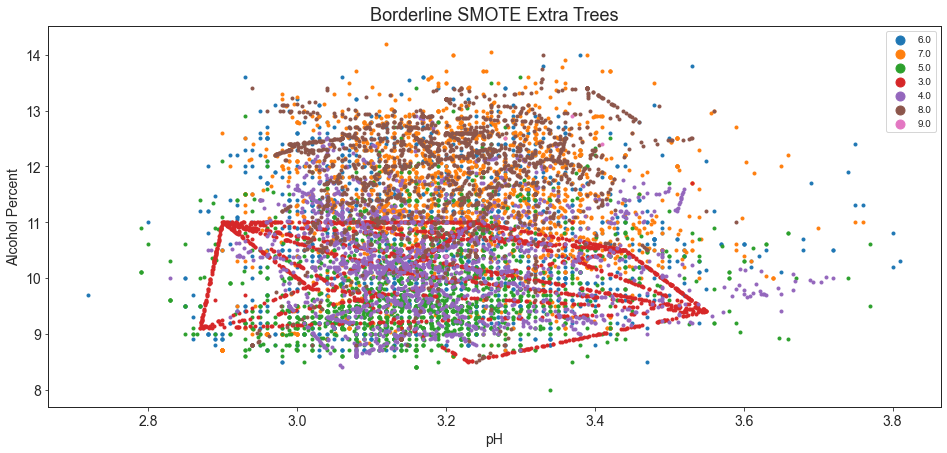

Report on accuracy of scaled Extra Trees Classification with BorderlineSMOTE
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 64.940% (2.645%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 11 out of 33 : 33.3%
number of 5s accurately predicted is 203 out of 291 : 69.8%
number of 6s accurately predicted is 309 out of 440 : 70.2%
number of 7s accurately predicted is 127 out of 176 : 72.2%
number of 8s accurately predicted is 16 out of 35 : 45.7%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 68.0%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.525668
MAD: 0.360204
[[  0   0   1   3   0   0   0]
 [  2  11  15   4   1   0   0]
 [  0  13 203  67   8   0   0]
 [  0   6  65 309  60   0   0]
 [  0   0   3  40 127   6   0]
 [  0   0   0   9  10  16   0]
 [  0   0   0   0   0   1   0]]
Accuracy_score based on rounding: 0

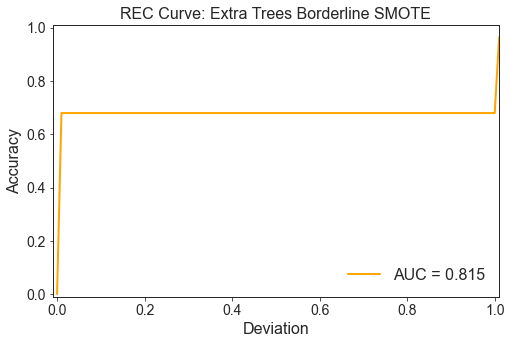

In [562]:
oversample = BorderlineSMOTE()
X_trainbsm, Y_trainbsm = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainbsm)
print('After BorderlineSMOTE:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainbsm == label)[0]
    plt.scatter(
    X_trainbsm[row_ix, 8], X_trainbsm[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('Borderline SMOTE Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of scaled Extra Trees Classification with BorderlineSMOTE')

imbPipeline=make_pipeline(
StandardScaler(),BorderlineSMOTE(
random_state=42, m_neighbors=4),ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features))

# evaluate pipeline
# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We don't want to oversample twice!
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline, X_train, Y_train, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline.fit(X_train,Y_train)
predictions = imbPipeline.predict(X_validation)
eval_final(X_validation, mtype='Extra Trees Borderline SMOTE',curve=False)


## Adding Extra Trees with Borderline Smote to the collection:

In [668]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


Although the weighted overall recall fell, the recall-4 and recall-8 both increased. This result currently leads the rest of the pack.

## SMOTE is a close relative of Borderline Smote. We will now compare its performance on the Extra Trees model.

After SMOTE: Counter({6.0: 1758, 7.0: 1758, 5.0: 1758, 3.0: 1758, 4.0: 1758, 8.0: 1758, 9.0: 1758})


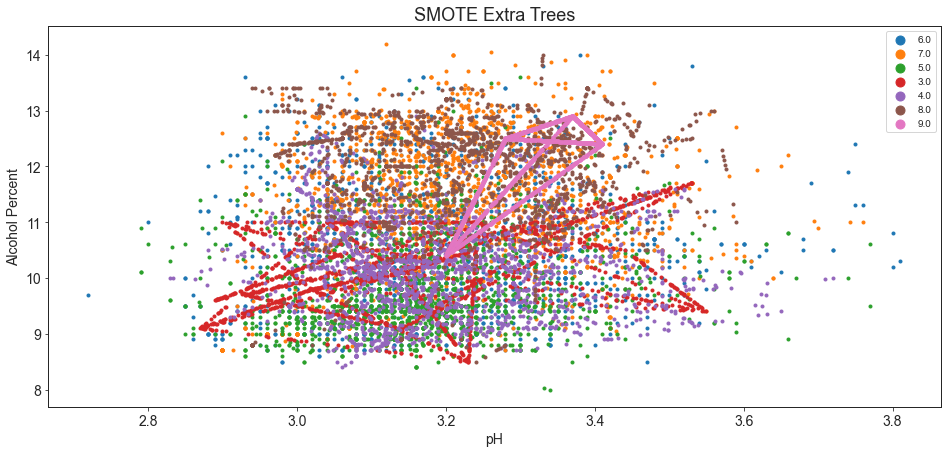

Report on accuracy of scaled Extra Trees Classification with SMOTE
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 65.229% (2.020%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 14 out of 33 : 42.4%
number of 5s accurately predicted is 202 out of 291 : 69.4%
number of 6s accurately predicted is 316 out of 440 : 71.8%
number of 7s accurately predicted is 120 out of 176 : 68.2%
number of 8s accurately predicted is 15 out of 35 : 42.9%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 68.1%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.527661
MAD: 0.373469
[[  0   0   1   2   1   0   0]
 [  2  14  13   3   1   0   0]
 [  1  10 202  68   9   1   0]
 [  3   7  55 316  57   2   0]
 [  0   0   4  43 120   9   0]
 [  0   0   0   8  12  15   0]
 [  0   0   0   0   1   0   0]]
Accuracy_score based on rounding: 0.680612244

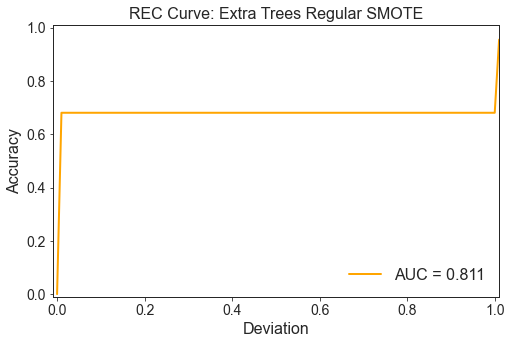

In [564]:
oversample = SMOTE(k_neighbors=3)
X_trainsm, Y_trainsm = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainsm)
print('After SMOTE:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainsm == label)[0]
    plt.scatter(
    X_trainsm[row_ix, 8], X_trainsm[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('SMOTE Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of scaled Extra Trees Classification with SMOTE')

# Use greater number of k_neighbors for the fitting of overall dataset
# Use smaller number of k_neighbors for the cross-validation on kfolds
imbPipeline1=make_pipeline(
StandardScaler(),SMOTE(k_neighbors=3),ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features))

imbPipeline2=make_pipeline(
StandardScaler(),SMOTE(k_neighbors=2),ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features))

# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We don't want to oversample twice!
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline2, X_train, Y_train, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline1.fit(X_train,Y_train)
predictions = imbPipeline1.predict(X_validation)
eval_final(X_validation, mtype='Extra Trees Regular SMOTE',curve=False)


## Adding Extra Trees with SMOTE to the collection:

In [669]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%']
       
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


This Extra Trees result raised the recall-4 significantly. While the recall-8 decreased slightly, the rest of the metrics stayed much the same. We have now achieved a weighted recall incrementally better than that of the 2009 study, but noticeably better for recall of low-scoring and high-scoring wines. The Kappa ahead of the 2009 study, and the Mean Absolute Deviation is lower (good), indicating that the misclassified wines in the confusion matrix are grouped more tightly around their actual values than they were in the 2009 model. The number of 'near misses' has increased while the number of 'complete misses' has fallen.

## Apply additional models experimentally.
There are many models we could try to improve upon the Extra Trees result, but we could never have enough space or time to apply all of them. Still, it is worth attempting a few to see whether slight improvements can be made to the classification of the positive classes.

## Mahalanobis Distance Oversampling with Extra Trees
Note that as of this writing MDO cannot be integrated into a pipeline with ensemble methods. Extra Trees is considered an ensemble method. Therefore, for the sake of experimentation, we must oversample the data on the entire training dataset, and tolerate the data leakage that results.

Acknowledgement:
The code for this method comes from the bachelor thesis titled 'Multi-imbalance:  Python package for multi-class imbalance learning', by Jacek Grycza, Damian Horna, Hanna Klimczak, Kamil Plucínski, Poznan University of Technology, Poznan, Poland, 2020.

Instructions for its installation may be found here:
https://github.com/damian-horna/multi-imbalance/blob/master/README.md


After MDO: Counter({6.0: 1758, 5.0: 1758, 7.0: 704, 8.0: 140, 4.0: 130, 3.0: 16, 9.0: 4})


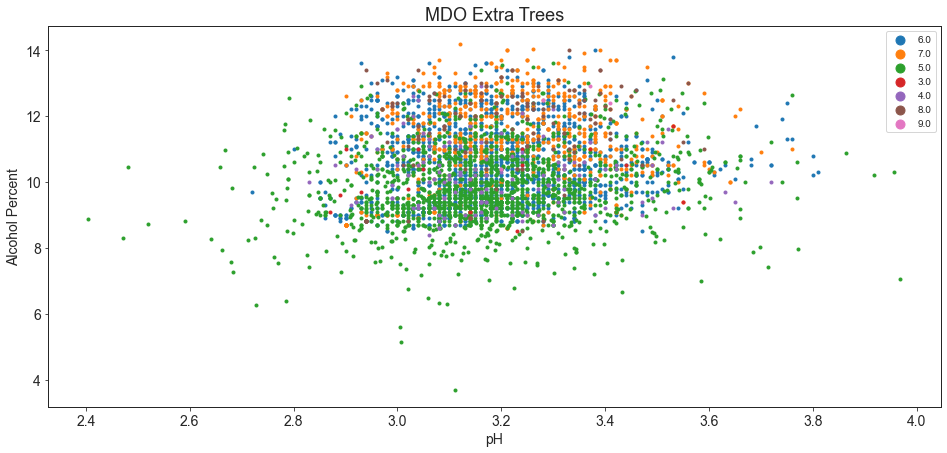

Report on accuracy of scaled Extra Trees Classification with MDO. Note that since the MDO is not in the pipeline, the cross validation will have data leakage
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 70.880% (1.984%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 6 out of 33 : 18.2%
number of 5s accurately predicted is 227 out of 291 : 78.0%
number of 6s accurately predicted is 333 out of 440 : 75.7%
number of 7s accurately predicted is 103 out of 176 : 58.5%
number of 8s accurately predicted is 15 out of 35 : 42.9%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 69.8%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.537932
MAD: 0.336735
[[  0   0   1   3   0   0   0]
 [  2   6  17   7   1   0   0]
 [  0   3 227  60   1   0   0]
 [  0   1  72 333  34   0   0]
 [  0   0   4  68 103   1   0]
 [  0   0   0  11 

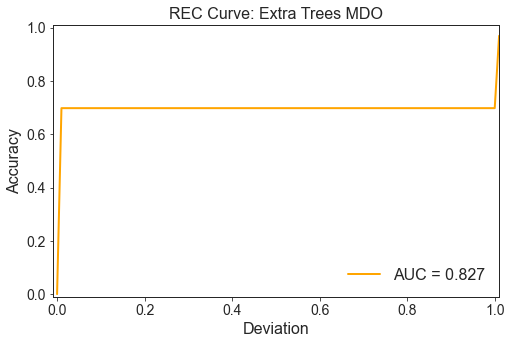

In [566]:
# Two dictionaries describes the base-0 ordered categories, on the basis of
# whether they are major or minor categories.
# 0 = 3; 1=4; 2=5; 3=6; 4=7; 5=8; 6=9
desc = {  # pragma no cover
    "new_winequality-red": {'maj': [2, 3, 4], 'int': [], 'min': [0, 1, 5]},
    "new_winequality-white": {'maj': [2 ,3, 4], 'int': [], 'min': [0, 1, 5, 6]}
}
if 'white' in dataset:
    oversample = MDO(
    k=5, k1_frac=0.3, maj_int_min=desc['new_winequality-white'])
else:
    oversample = MDO(k=5, k1_frac=0.3, maj_int_min=desc['new_winequality-red'])

X_trainmdo, Y_trainmdo = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainmdo)
print('After MDO:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainmdo == label)[0]
    plt.scatter(
    X_trainmdo[row_ix, 8], X_trainmdo[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('MDO Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print('Report on accuracy of scaled Extra Trees Classification with MDO. \
Note that since the MDO is not in the pipeline, the cross validation \
will have data leakage')

model=Pipeline([('Scaler', StandardScaler()),(
'Extra Trees', ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features,class_weight='balanced'))])

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(model, X_trainmdo, Y_trainmdo, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_trainmdo,Y_trainmdo)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='Extra Trees MDO',curve=False)


## Adding Extra Trees with Mahalanobis Distance Oversampling (MDO) to the collection:

In [670]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


The MDO with Extra Trees overall performs well, but at the expense of a loss of accuracy in recall-4. Extra Trees with scaling and SMOTE still appears to be the winner, the model most likely to succeed in both imbalanced learning and in overall classification accuracy.

## Mahalanobis Distance Oversampling with Random Forests
It seems worth checking on whether a different ensemble method could yield better results from imbalanced learning when associated with MDO. We will try pairing MDO with Random Forests.

After MDO: Counter({6.0: 1758, 5.0: 1758, 7.0: 704, 8.0: 140, 4.0: 130, 3.0: 16, 9.0: 4})


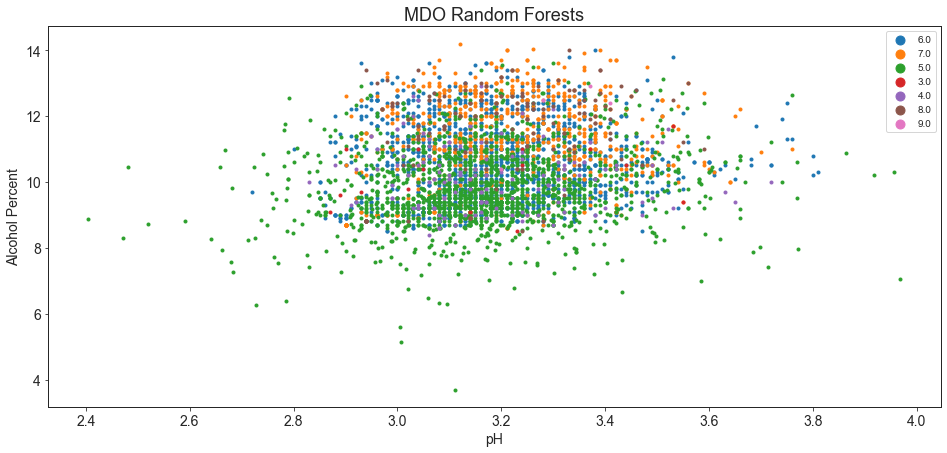

Report on accuracy of scaled Random Forest Classification with MDO. Note that since the MDO is not in the pipeline, cross validation will have data leakage
Random Forest Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 70.414% (2.074%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 5 out of 33 : 15.2%
number of 5s accurately predicted is 220 out of 291 : 75.6%
number of 6s accurately predicted is 344 out of 440 : 78.2%
number of 7s accurately predicted is 105 out of 176 : 59.7%
number of 8s accurately predicted is 14 out of 35 : 40.0%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 70.2%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.541489
MAD: 0.328571
[[  0   0   1   3   0   0   0]
 [  1   5  24   3   0   0   0]
 [  0   2 220  68   1   0   0]
 [  0   0  68 344  28   0   0]
 [  0   0   6  64 105   1   0]
 [  0   0   0  12 

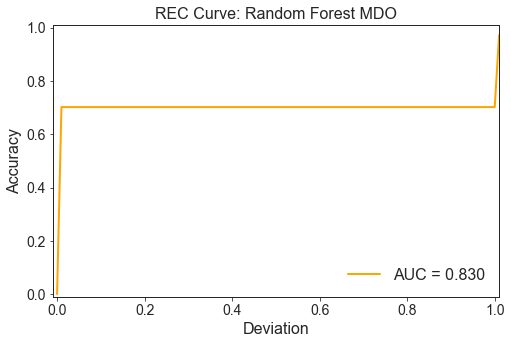

In [568]:
desc = {  # pragma no cover
    "new_winequality-red": {'maj': [2, 3, 4], 'int': [], 'min': [0, 1, 5]},
    "new_winequality-white": {'maj': [2 ,3, 4], 'int': [], 'min': [0, 1, 5, 6]}
}
if 'white' in dataset:
    oversample = MDO(
    k=5, k1_frac=0.3, maj_int_min=desc['new_winequality-white'])
else:
    oversample = MDO(k=5, k1_frac=0.3, maj_int_min=desc['new_winequality-red'])

X_trainmdo, Y_trainmdo = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainmdo)
print('After MDO:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainmdo == label)[0]
    plt.scatter(
    X_trainmdo[row_ix, 8], X_trainmdo[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('MDO Random Forests',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of scaled Random Forest Classification with MDO. \
Note that since the MDO is not in the pipeline, cross validation \
will have data leakage')

model=Pipeline([('Scaler', StandardScaler()),(
'Random Forest', RandomForestClassifier(
n_estimators=num_trees, max_features=n_components, class_weight='balanced'))])

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(model, X_trainmdo, Y_trainmdo, cv=kfold)
print('Random Forest Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_trainmdo,Y_trainmdo)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='Random Forest MDO',curve=False)


## Adding Random Forests with Mahalanobis Distance Oversampling (MDO) to the collection:

In [671]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study',
                 'this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees','Random Forests'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO','Scaled, MDO'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%','70.2%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8','54.1'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34','.33'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%','15.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%','40.0%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


Mahalanobis Distance Oversampling with Random Forests is not as skillful as Extra Trees at classifying the imbalanced portion of the data. Extra Trees emerged early on from the box-plot comparisons as a potential favorite as compared with other models. It appears to be meeting those early expectations.

## SMOTE Edited Nearest Neighbors (SMOTEENN) with random oversampling is a method of combining oversampling with undersampling.
This application undersamples only the majority classes, removing only those examples that are misclassified. The dataset as a whole is, at the same time, oversampled, both with the random oversampling method and the SMOTE method. Sometimes this combination of oversampling and undersampling can yield good results, but it is an experiment, and we will need to see. We will align these techniques with the Extra Trees model.

After SMOTEENN: Counter({3.0: 1758, 4.0: 1758, 5.0: 1758, 6.0: 1758, 7.0: 1758, 8.0: 1758, 9.0: 1758})


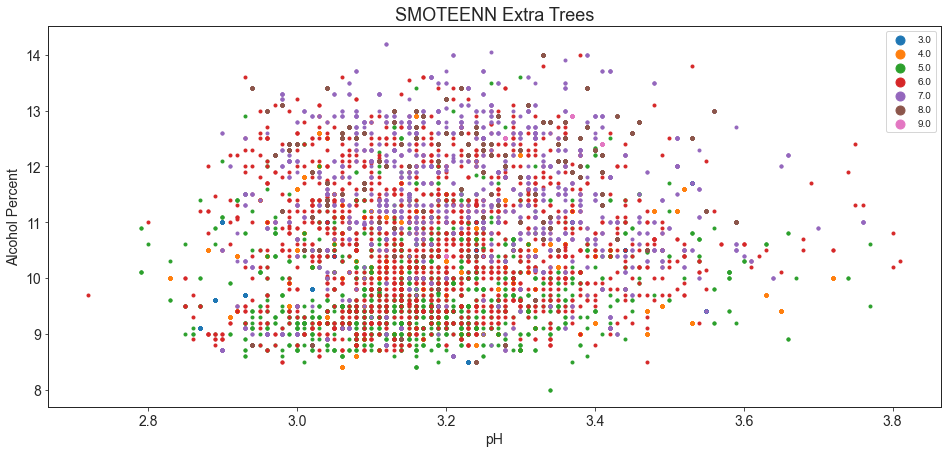

Report on accuracy of scaled Extra Trees Classification with SMOTEENN
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 67.262% (2.183%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 8 out of 33 : 24.2%
number of 5s accurately predicted is 206 out of 291 : 70.8%
number of 6s accurately predicted is 352 out of 440 : 80.0%
number of 7s accurately predicted is 104 out of 176 : 59.1%
number of 8s accurately predicted is 14 out of 35 : 40.0%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 69.8%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.533935
MAD: 0.338776
[[  0   0   1   3   0   0   0]
 [  1   8  15   8   1   0   0]
 [  0   4 206  80   1   0   0]
 [  0   1  51 352  36   0   0]
 [  0   0   4  67 104   1   0]
 [  0   0   0  12   9  14   0]
 [  0   0   0   0   1   0   0]]
Accuracy_score based on rounding: 0.6979591

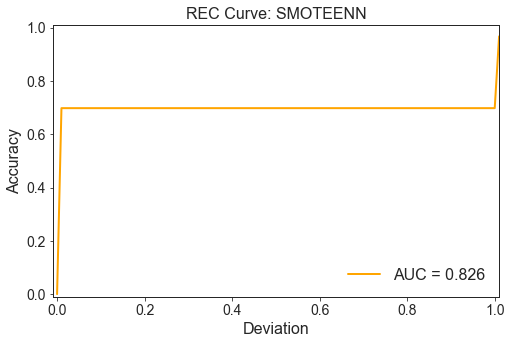

In [571]:
oversample = RandomOverSampler()
X_trainov, Y_trainov = oversample.fit_resample(X_train, Y_train)
# Only remove examples from the majority
oversample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_trainsm, Y_trainsm = oversample.fit_resample(X_trainov, Y_trainov)
counter=Counter(Y_trainsm)
print('After SMOTEENN:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainsm == label)[0]
    plt.scatter(
    X_trainsm[row_ix, 8], X_trainsm[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('SMOTEENN Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of scaled Extra Trees Classification with SMOTEENN')
# Use greater number of k_neighbors for the fitting of overall dataset
# Use smaller number of k_neighbors for the cross-validation on kfolds
imbPipeline=make_pipeline(RandomOverSampler(),
StandardScaler(),oversample,ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features))

# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We don't want to oversample twice!
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline, X_train, Y_train, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline.fit(X_train,Y_train)
predictions = imbPipeline.predict(X_validation)
eval_final(X_validation, mtype='SMOTEENN',curve=False)


## Adding Extra Trees with SMOTEENN with Oversampling to the collection:

In [672]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study',
                 'this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees','Random Forests','Extra Trees'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO','Scaled, MDO',
                          'Scaled, undersample, oversample'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%','70.2%','69.8%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8','54.1','53.4'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34','.33','.34'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%','15.2%','24.2%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%','40.0%','40.0%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


The undersampling-oversampling strategy was skillful, but its imbalanced learning did not exceed that of Extra Trees with SMOTE.

## Adaptive Synthetic Oversampling (ADASYN) is a variation of SMOTE that oversamples minority classes based upon their relative density.
This slight variation of SMOTE can sometimes yield decision boundaries that are easier for a model to recognize.



After ADASYN: Counter({5.0: 1815, 7.0: 1771, 6.0: 1758, 9.0: 1756, 3.0: 1755, 4.0: 1738, 8.0: 1735})


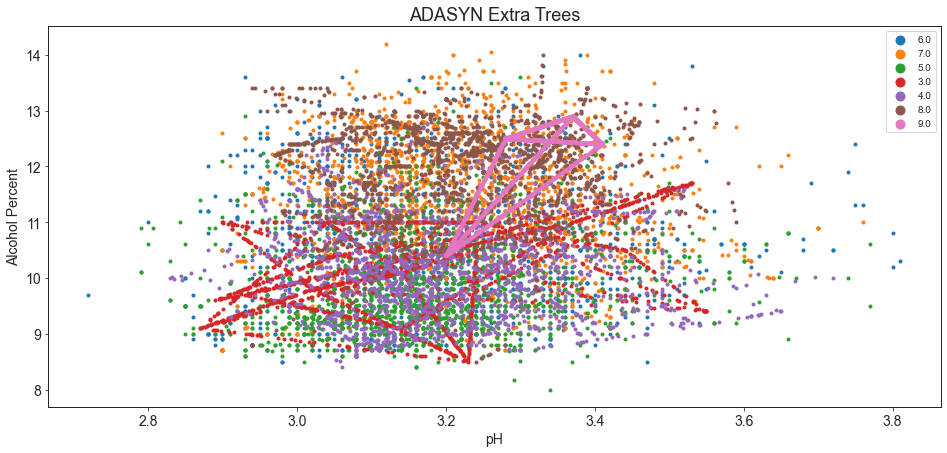

Report on accuracy of scaled Extra Trees Classification with ADASYN
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 64.693% (2.717%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 12 out of 33 : 36.4%
number of 5s accurately predicted is 208 out of 291 : 71.5%
number of 6s accurately predicted is 291 out of 440 : 66.1%
number of 7s accurately predicted is 128 out of 176 : 72.7%
number of 8s accurately predicted is 15 out of 35 : 42.9%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 66.7%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.513918
MAD: 0.387755
[[  0   0   1   2   1   0   0]
 [  2  12  13   5   1   0   0]
 [  1  11 208  62   8   1   0]
 [  1   6  68 291  70   3   1]
 [  0   0   6  32 128  10   0]
 [  0   0   0   9  11  15   0]
 [  0   0   0   0   0   1   0]]
Accuracy_score based on rounding: 0.66734693

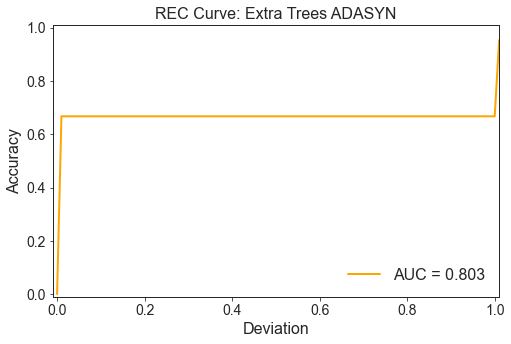

In [573]:
# ADASYN strategy for best classifier: Extra Trees
# Adaptive Synthetic Sampling Strategy is very similar to SMOTE
# Notice the class weight of balanced has little impact on the accuracy
# Try the model with and without the class weight of 'balanced'
print()
print()
oversample = ADASYN(n_neighbors=3)
X_trainsm, Y_trainsm = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainsm)
print('After ADASYN:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainsm == label)[0]
    plt.scatter(
    X_trainsm[row_ix, 8], X_trainsm[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('ADASYN Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of scaled Extra Trees Classification with ADASYN')
# class_weight seems to have little effect when the data is oversampled
# prior to application of the Extra Trees model
# Use greater number of k_neighbors for the fitting of overall dataset
# Use smaller number of k_neighbors for the cross-validation on kfolds
imbPipeline1=make_pipeline(
StandardScaler(),ADASYN(n_neighbors=3),ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features,class_weight='balanced'))

imbPipeline2=make_pipeline(
StandardScaler(),ADASYN(n_neighbors=2),ExtraTreesClassifier(
n_estimators=num_trees,max_features=max_features,class_weight='balanced'))

# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We don't want to oversample twice!
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline2, X_train, Y_train, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline1.fit(X_train,Y_train)
predictions = imbPipeline1.predict(X_validation)
eval_final(X_validation, mtype='Extra Trees ADASYN',curve=False)


## Adding ADASYN with Extra Trees to the collection:

In [674]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study',
                 'this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees','Random Forests','Extra Trees','Extra Trees'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO','Scaled, MDO',
                          'Scaled, undersample, oversample','Scaled, ADASYN'],
         'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%','70.2%','69.8%','66.7%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8','54.1','53.4','51.4'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34','.33','.34',
              '.39'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%','15.2%','24.2%','36.4%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%','40.0%','40.0%','42.9%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


ADASYN with Extra Trees achieved a competitive weighted recall and KAPPA, along with quite respectable Mean Absolute Deviation (MAD). Recall-4 is high at 36.4%, as is recall-8 at 42.9%. Overall, this model achieves an excellent blend of skillful imbalanced learning with overall accuracy and a low Mean Absolute Deviation.

## AdaBoost Classification is a method of sampling in such a way as to bias the model toward  misclassified examples.


AdaBoost Classification: 30 trees
Cross Validation Accuracy: 43.739% (3.910%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 0 out of 33 : 0.0%
number of 5s accurately predicted is 4 out of 291 : 1.4%
number of 6s accurately predicted is 389 out of 440 : 88.4%
number of 7s accurately predicted is 45 out of 176 : 25.6%
number of 8s accurately predicted is 0 out of 35 : 0.0%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 44.7%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.052427
MAD: 0.624490
[[  0   0   0   2   2   0   0]
 [  0   0   2  29   2   0   0]
 [  0   0   4 285   2   0   0]
 [  0   0   3 389  47   0   1]
 [  0   0   0 131  45   0   0]
 [  0   0   0  22  13   0   0]
 [  0   0   0   0   1   0   0]]
Accuracy_score based on rounding: 0.44693877551020406
Precision_score based on rounding: 0.4076885699334679
              precision    recall  f1-score   support

         3.

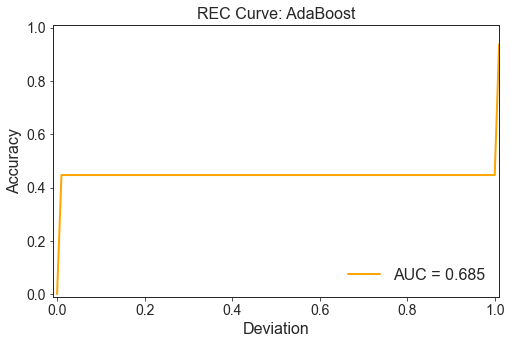

In [575]:
# These other ensembles perform less well on the dataset
# AdaBoost Classification
# Hui Han: "Adaboost increases the weights of misclassified examples and
# decreases [the weights of] those correctly classified using the same
# proportion, without considering the imbalance of the data sets."
num_trees = 30
seed=7
#kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
model=Pipeline([('Scaler', StandardScaler()),(
'AdaBoost', AdaBoostClassifier(
n_estimators=num_trees, random_state=seed))])
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print()
print("AdaBoost Classification: 30 trees")
print("Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='AdaBoost',curve=False)


## Adding AdaBoost to the collection:

In [675]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study',
                 'this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees','Random Forests','Extra Trees','Extra Trees',
                'AdaBoost'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO','Scaled, MDO',
                          'Scaled, undersample, oversample','Scaled, ADASYN','Scaled'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%','70.2%','69.8%','66.7%','44.7%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8','54.1','53.4','51.4','5.2'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34','.33','.34',
              '.39','.62'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%','15.2%','24.2%','36.4%','0.0%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%','40.0%','40.0%','42.9%','0.0%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


AdaBoost performed worse than any other model thus far tried. Its result, according to the Kappa score, is very close to that which could have been achieved by guessing. With more experience, I may come to learn whether some combination of sampling, modification of hyperparameters, or feature selection might improve the skill of this model.

## Stochastic Gradient Boosting selects small sub-samples from the data and builds a decision tree from each one. The sub-sample approach is intended to counteract over-fitting.


Stochastic Gradient Boosting Classification: 100 trees
Cross Validation Accuracy: 59.256% (2.204%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 10 out of 33 : 30.3%
number of 5s accurately predicted is 162 out of 291 : 55.7%
number of 6s accurately predicted is 321 out of 440 : 73.0%
number of 7s accurately predicted is 67 out of 176 : 38.1%
number of 8s accurately predicted is 8 out of 35 : 22.9%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 58.0%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.343903
MAD: 0.474490
[[  0   0   1   3   0   0   0]
 [  2  10  15   6   0   0   0]
 [  0   7 162 114   7   1   0]
 [  0   3  79 321  33   3   1]
 [  0   0   6 101  67   1   1]
 [  0   0   0  15  11   8   1]
 [  0   0   0   0   1   0   0]]
Accuracy_score based on rounding: 0.5795918367346938
Precision_score based on rounding: 0.5801962576699088
              precision    recall  f1-sc

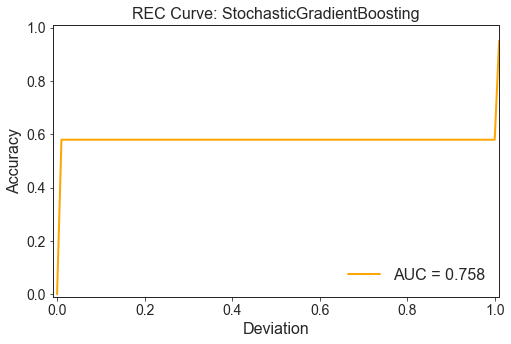

In [577]:
# Stochastic Gradient Boosting Classification
seed = 7
num_trees = 100
#kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
model=Pipeline([('Scaler', StandardScaler()),(
'StochasticGB', GradientBoostingClassifier(
n_estimators=num_trees, random_state=seed))])
#model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print()
print('Stochastic Gradient Boosting Classification: 100 trees')
print("Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
eval_final(X_validation, mtype='StochasticGradientBoosting',curve=False)


## Adding Stochastic Gradient Boosting to the collection:

In [676]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study',
                 'this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees','Random Forests','Extra Trees','Extra Trees',
                'AdaBoost','Stochastic Gradient Boosting'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO','Scaled, MDO',
                          'Scaled, undersample, oversample','Scaled, ADASYN','Scaled','Scaled'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%','70.2%','69.8%','66.7%','44.7%','58.0%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8','54.1','53.4','51.4','5.2','34.4'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34','.33','.34',
              '.39','.62','.47'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%','15.2%','24.2%','36.4%','0.0%','30.3%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%','40.0%','40.0%','42.9%','0.0%','22.9%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


Stochastic Gradient Boosting is fairly competitive with other models, even as compared with the 2009 study, but it does not achieve the levels of performance obtained with Extra Trees.

## Combining calibration of probabilities with Extra Trees can harness the ability of a model to reflect true probability rather than a probability of prediction that may be biased towards the majority classes.



After BorderlineSMOTE (calibr. prob.): Counter({6.0: 1758, 7.0: 1758, 5.0: 1758, 3.0: 1758, 4.0: 1758, 8.0: 1758, 9.0: 4})


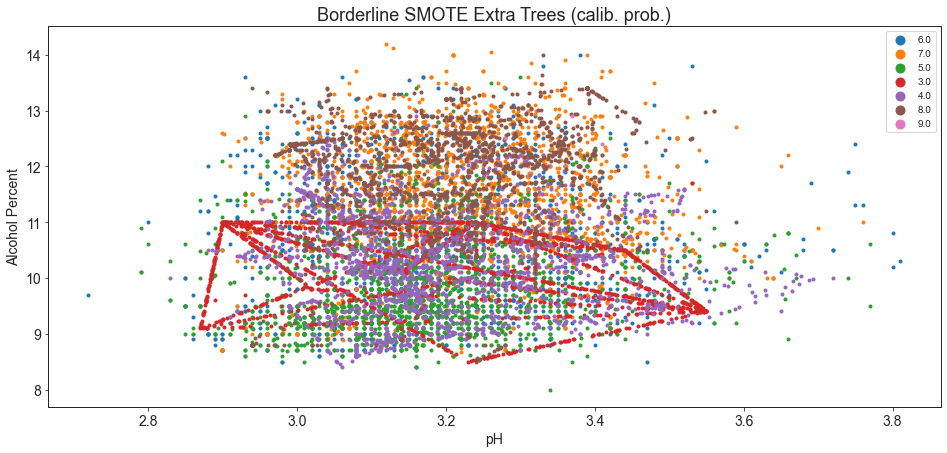

Report on accuracy of scaled Extra Trees Classification with Calibrated Probabilities and BorderlineSMOTE
Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 66.360% (2.498%)
Tolerance: 0.5
number of 3s accurately predicted is 0 out of 4 : 0.0%
number of 4s accurately predicted is 13 out of 33 : 39.4%
number of 5s accurately predicted is 196 out of 291 : 67.4%
number of 6s accurately predicted is 333 out of 440 : 75.7%
number of 7s accurately predicted is 121 out of 176 : 68.8%
number of 8s accurately predicted is 16 out of 35 : 45.7%
number of 9s accurately predicted is 0 out of 1 : 0.0%
Total percentage predicted correctly: 69.3%
Kappa (1=perfect;0=chance;<0=worse than chance): 0.539163
MAD: 0.342857
[[  0   0   1   3   0   0   0]
 [  2  13  11   6   1   0   0]
 [  0  11 196  79   5   0   0]
 [  0   4  50 333  53   0   0]
 [  0   0   3  46 121   6   0]
 [  0   0   0   8  11  16   0]
 [  0   0   0   0   0   1   0]]
Accura

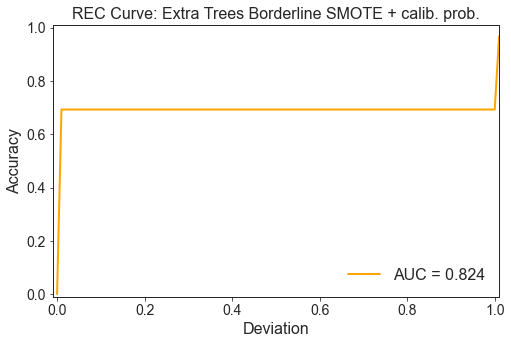

In [579]:
# Borderline SMOTE strategy for best classifier: Extra Trees with
# Calibrated Probabilities
print()
print()
oversample = BorderlineSMOTE()
X_trainbsm, Y_trainbsm = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainbsm)
print('After BorderlineSMOTE (calibr. prob.):',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainbsm == label)[0]
    plt.scatter(
    X_trainbsm[row_ix, 8], X_trainbsm[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('Borderline SMOTE Extra Trees (calib. prob.)',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of scaled Extra Trees Classification with \
Calibrated Probabilities and BorderlineSMOTE')

model=ExtraTreesClassifier(n_estimators=num_trees,max_features=max_features)
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)

imbPipeline=make_pipeline(
StandardScaler(),BorderlineSMOTE(
random_state=42, m_neighbors=4),calibrated)
# evaluate pipeline
# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We do not want to oversample twice!

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline, X_train, Y_train, cv=kfold)
print('Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline.fit(X_train,Y_train)
predictions = imbPipeline.predict(X_validation)
eval_final(X_validation, mtype='Extra Trees Borderline SMOTE + calib. prob.',
curve=False)


## Adding Extra Trees with Calibrated Probabilities to the collection:

In [680]:
import pandas as pd
 
# initialize data of lists.
data = {'Source':['2009 study','this study','this study','this study','this study','this study',
                  'this study','this study','this study','this study','this study','this study','this study',
                 'this study','this study','this study','this study','this study','this study'],
        'Model':['Support Vector Regression','Support Vector Regression','Support Vector Regression',
                 'K-Nearest Neighbors','Support Vector Classifier','CART',
                 'Balanced Bagged Decision Trees','Bagged Decision Trees','Random Forests','Extra Trees',
                'Extra Trees','Extra Trees','Extra Trees','Random Forests','Extra Trees','Extra Trees',
                'AdaBoost','Stochastic Gradient Boosting','Extra Trees'],
        'Characteristics':['feature selection, tolerances','Scaled','Tuned and Scaled','Tuned and Scaled',
                          'Scaled, weighted, best features','Scaled, best features','Scaled, best features',
                          'Scaled, best features','Scaled, best features','Scaled, random oversampling',
                          'Scaled, Borderline SMOTE','Scaled, SMOTE','Scaled, MDO','Scaled, MDO',
                          'Scaled, undersample, oversample','Scaled, ADASYN','Scaled','Scaled',
                          'Scaled, Calib. Probabilities, Borderline SMOTE'],
        'weighted recall':['64.6%','57.0%','66.2%','56.0%','43.7%','63.6%','29.5%','69.5%','70.1%','70.4%',
                          '68.0%','68.1%','69.8%','70.2%','69.8%','66.7%','44.7%','58.0%','69.3%'],
        'Kappa(%)':['43.9','32.4','45.5','31.1','26.1','46.2','12.4','53.0','53.8','54.1','52.6','52.8',
                   '53.8','54.1','53.4','51.4','5.2','34.4','53.9'],
        'MAD':['.45','.51','.45','.53','73','.45','1.11','.34','.33','.33','.36','.37','.34','.33','.34',
              '.39','.62','.47','.34'],
        'recall-4':['11.7%','12.1%','0.0%','0.0%','51.5%','18.2%','51.5%','24.2%','21.2%','21.2%','33.3%',
                   '42.4%','18.2%','15.2%','24.2%','36.4%','0.0%','30.3%','39.4%'],
        'recall-8':['33.5%','0.0%','5.7%','5.7%','40.0%','45.7%','28.6%','40.0%','37.1%','42.9%','45.7%',
                   '42.9%','42.9%','40.0%','40.0%','42.9%','0.0%','22.9%','45.7%']
       
       }
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
df

,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


Calibrating the probabilities created a model that is highly competitive. 

## Experiment with Binary Classification
Many machine learning datasets have a simple division of the positive and the negative classes, in contrast to the wine dataset, which has four positive classes (3,4,8,9), and three negative classes (5,6,7). As an experiment, I would like to find out what would happen if the wine dataset were to be re-categorized as a binary, two-class dataset, positive or negative, rather than the multiple categories of data we have been using.

First, we will re-classify the Y training dataset by separating out the excellent wines (categories 8 or 9) from the rest. Then, we will try out an assortment of different models to see whether any are notably successful in classification with the new binary data arrangement.

Brier skill score>LR 0.039 (0.034)
Brier skill score>LDA 0.036 (0.038)
Brier skill score>QDA -0.416 (0.156)
Brier skill score>GNB -0.642 (0.220)
Brier skill score>GPC -0.891 (0.082)
Brier skill score>Extra Trees 0.326 (0.111)
(1=perfect;0=chance;<0=worse than chance)


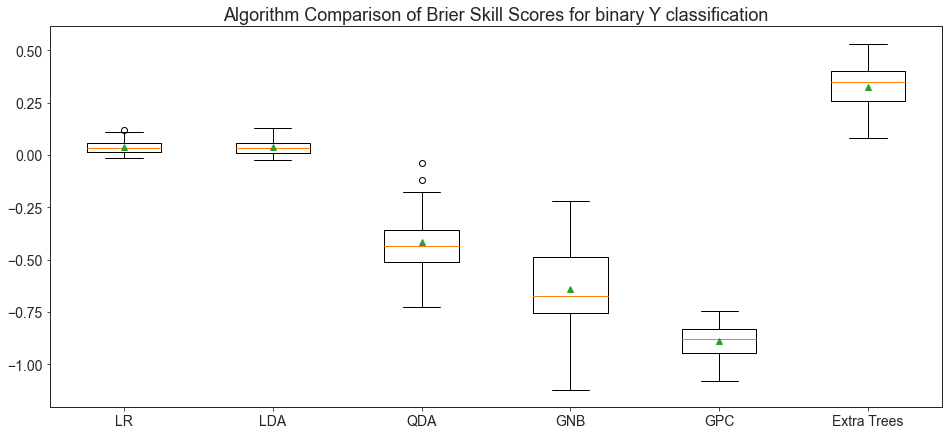



After reassignment of Y to binary classes: Counter({0: 3774, 1: 144})


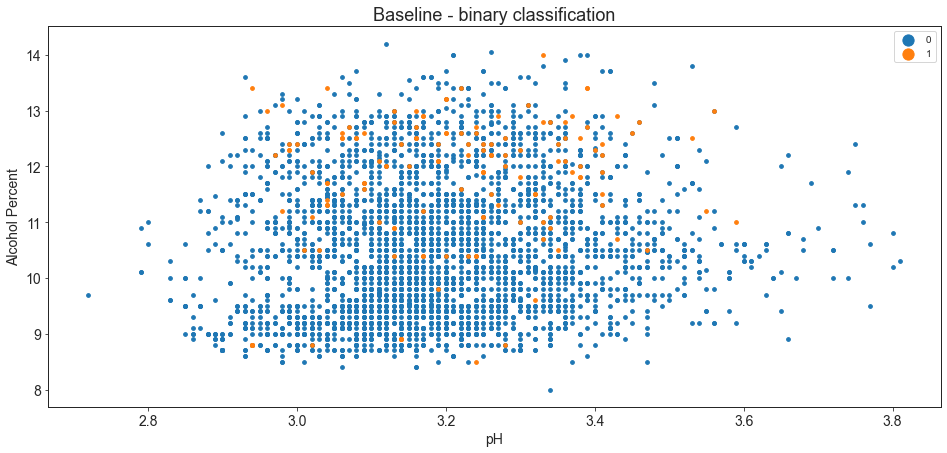

In [604]:
# Re-classify y==8 or y==9 as the positive class 1: a wine judged excellent
# Re-classify all others as the negative class 0: a wine not judged excellent
Y_train_new=list()
incr=0
for y in Y_train:
    incr+=1
    if y==8 or y==9:
        Y_train_new.append(1)
    else:
        Y_train_new.append(0)
from numpy import array
Y_train_newa=array(Y_train_new)

Y_validation_new=list()
incr=0
for y in Y_validation:
    incr+=1
    if y==8 or y==9:
        Y_validation_new.append(1)
    else:
        Y_validation_new.append(0)
Y_validation_newa=array(Y_validation_new)

# compare probabilistic models with standardized input
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
  # calculate reference brier score
  # 175+5 = 4898 = .0367 = percent of 8 and 9 in data for white wine
  if 'white' in filename:
      ref_probs = [0.0367 for _ in range(len(y_true))]
  else:
      ref_probs = [0.157 for _ in range(len(y_true))]
  bs_ref = brier_score_loss(y_true, ref_probs)
  # calculate model brier score
  bs_model = brier_score_loss(y_true, y_prob)
  # calculate skill score
  return 1.0 - (bs_model / bs_ref)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(brier_skill_score, needs_proba=True)
  # evaluate model
  scores = cross_val_score(
  model, X_train, Y_train_newa, scoring=metric, cv=cv, n_jobs=-1)
  return scores

 # define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # QDA
    models.append(QuadraticDiscriminantAnalysis())
    names.append('QDA')
    # GNB
    models.append(GaussianNB())
    names.append('GNB')
    # GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    # Extra Trees
    models.append(ExtraTreesClassifier(n_estimators=100,max_features=8))
    names.append('Extra Trees')
    return models, names

models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # create a pipeline
  pipeline = Pipeline(steps=[('t', StandardScaler()),('m',models[i])]) # evaluate the model and store results
  scores = evaluate_model(X_train, Y_train_newa, pipeline)
  results.append(scores)
  # summarize and store
  print('Brier skill score>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
print('(1=perfect;0=chance;<0=worse than chance)')
# plot the results
plt.title('Algorithm Comparison of Brier Skill Scores for binary Y classification',fontsize=18)
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Logistic Regression for binary classifier
print()
print()
counter=Counter(Y_train_newa)
print('After reassignment of Y to binary classes:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_train_newa == label)[0]
    plt.scatter(
    X_train[row_ix, 8], X_train[row_ix, 10], label=str(label), alpha=1, s=14)
plt.title('Baseline - binary classification',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The imbalance is still noticeable when the positive (excellent) wines are separated from all others. As previously, Extra Trees is found to perform more skillfully than the other models. We can supplement Extra Trees with oversampling in the hope of enhancing the model's skill at imbalanced classification to a greater extent than was possible in a multi-categorical arrangement.

## Combine the binary categorization with SMOTE and calibrated probabilities. Discover whether this will improve the skill of the model at distinguishing an excellent wine from the rest.

After Binary Y SMOTE: Counter({0: 3774, 1: 3774})


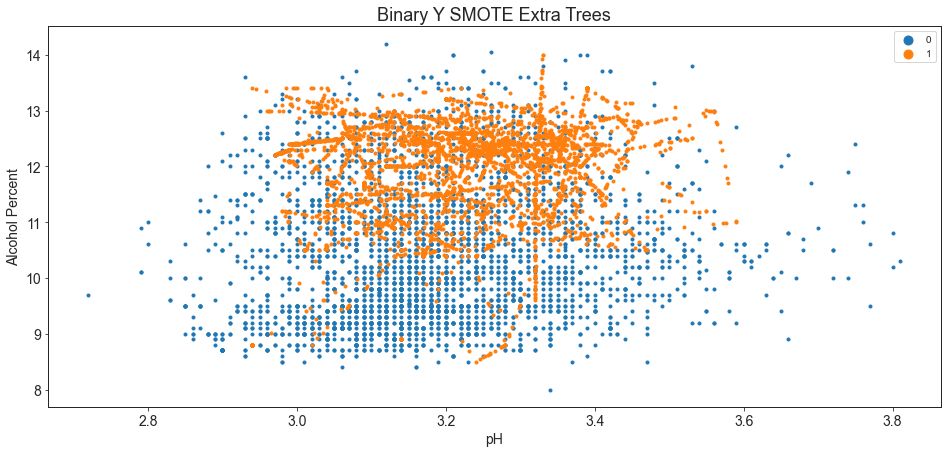

Report on accuracy of Binary Y scaled Extra Trees Classification with SMOTE
Binary Y Extra Trees Classification: 100 trees; splits chosen from random selection of 8 features
Cross Validation Accuracy: 96.988% (0.533%)
Kappa (1=perfect;0=chance;<0=worse than chance): 0.594211
MAD (Mean Absolute Dev): 0.021429
[[943   1]
 [ 20  16]]
Accuracy: 0.9785714285714285
Precision: 0.0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       944
           1       0.94      0.44      0.60        36

    accuracy                           0.98       980
   macro avg       0.96      0.72      0.80       980
weighted avg       0.98      0.98      0.97       980



In [582]:
# SMOTE strategy for best classifier: Extra Trees with
# Calibrated Probabilities
oversample = SMOTE(k_neighbors=3)
X_trainbsm, Y_trainbsm = oversample.fit_resample(X_train, Y_train_newa)
counter=Counter(Y_trainbsm)
print('After Binary Y SMOTE:',counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(Y_trainbsm == label)[0]
    plt.scatter(
    X_trainbsm[row_ix, 8], X_trainbsm[row_ix, 10], label=str(label), alpha=1, s=9)
plt.title('Binary Y SMOTE Extra Trees',fontsize=18)
plt.legend(markerscale=3, fontsize=10)
plt.xlabel("pH",fontsize=14)
plt.ylabel("Alcohol Percent",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

num_trees=100
max_features=8
print(
'Report on accuracy of Binary Y scaled Extra Trees Classification with \
SMOTE')

model=ExtraTreesClassifier(n_estimators=num_trees,max_features=max_features)
#calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)

imbPipeline=make_pipeline(
StandardScaler(),SMOTE(k_neighbors=2),model)
# evaluate pipeline
# Note that the pipeline already contains the oversample task, and one should
# not use the already-oversampled data! We do not want to oversample twice!

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
results = cross_val_score(imbPipeline, X_train, Y_train_newa, cv=kfold, scoring='accuracy')
print('Binary Y Extra Trees Classification: 100 trees; splits chosen from ' \
'random selection of ' + str(max_features) + ' features')
print(
"Cross Validation Accuracy: %.3f%% (%.3f%%)" % (
results.mean()*100.0, results.std()*100.0))
imbPipeline.fit(X_train,Y_train_newa)
predictions = imbPipeline.predict(X_validation)
kappa=cohen_kappa_score(Y_validation_newa, np.around(predictions,0))
MAD = mean_absolute_error(Y_validation_newa, predictions)
print('Kappa (1=perfect;0=chance;<0=worse than chance): %f' % kappa)
print('MAD (Mean Absolute Dev): %f' % MAD)
print(confusion_matrix(Y_validation_newa, predictions))
print('Accuracy:',accuracy_score(Y_validation_newa, predictions))
print('Precision:',precision_score(
Y_validation,predictions,average='weighted'))
print(classification_report(Y_validation_newa, predictions, zero_division=1))


These results highlight the paradox of accuracy. Most of the examples are in the negative class. Most of the predictions, too, are in the negative class. This yields a high accuracy overall, but, in this example, pure chance (and a knowledge of the chance probability of either class) would also have yielded high accuracy. While the recall of the negative class is not abysmal, it is no higher than the recall exhibited in multi-categorical models. Therefore, I would conclude that there is no intrinsic benefit in re-casting this data as a binary classification problem.

## Conclusions

In [703]:
def custom_style(row):

    color = 'white'
    if 'ADASYN' in row.values[2] or 'Scaled, SMOTE'==row.values[2] or 'Calib' in row.values[2]:
        color = 'gold'
    if '2009' in row.values[0]:
        color = 'springgreen'

    return ['background-color: %s' % color]*len(row.values)

df=df.style.apply(custom_style, axis=1)
#df=df.data
display(df)
#lst=['2009 study']
#df.style.apply(lambda x: ['background: springgreen' if (set(lst).intersection(x.values)) 
#                              else '' for i in x], 
 #                  axis=1)



,Source,Model,Characteristics,weighted recall,Kappa(%),MAD,recall-4,recall-8
0,2009 study,Support Vector Regression,"feature selection, tolerances",64.6%,43.9,.45,11.7%,33.5%
1,this study,Support Vector Regression,Scaled,57.0%,32.4,.51,12.1%,0.0%
2,this study,Support Vector Regression,Tuned and Scaled,66.2%,45.5,.45,0.0%,5.7%
3,this study,K-Nearest Neighbors,Tuned and Scaled,56.0%,31.1,.53,0.0%,5.7%
4,this study,Support Vector Classifier,"Scaled, weighted, best features",43.7%,26.1,73,51.5%,40.0%
5,this study,CART,"Scaled, best features",63.6%,46.2,.45,18.2%,45.7%
6,this study,Balanced Bagged Decision Trees,"Scaled, best features",29.5%,12.4,1.11,51.5%,28.6%
7,this study,Bagged Decision Trees,"Scaled, best features",69.5%,53.0,.34,24.2%,40.0%
8,this study,Random Forests,"Scaled, best features",70.1%,53.8,.33,21.2%,37.1%
9,this study,Extra Trees,"Scaled, random oversampling",70.4%,54.1,.33,21.2%,42.9%


I would select ADASYN, Extra Trees with SMOTE, or Extra Trees with calibrated probabilities, highlighted in <font color='goldenrod'>gold</font> above, as my candidates to improve upon the classification work of the 2009 study of vinho verde wines from Portugal, highlighted in <font color='green'>green</font>. Any of these would perform well against the original 2009 SVR model.

My Support Vector Regression model, after tuning the hyperparameters and scaling the data with the standard scaler on each kfold, was able to obtain a ballpark resemblance to the accuracy of the 2009 study. However, my SVR model did not achieve the recall of the positive classes that the study authors did. This may be due to the fact that the authors' selection of key features was more technically sophisticated, and based on better domain knowledge of winemaking than I currently possess. 

As my study progressed, however, I was able to demonstrate that classification models such as Extra Trees, paired with oversampling algorithms such as Adaptive Synthetic Sampling, Synthetic Minority Oversampling (SMOTE) and Mahalanobis Distance Oversampling (MDO), achieve a predictive power that exceeds that of regression models such as SVR, especially in their ability to predict the positive classes, which are the wines on the high and low end of the quality spectrum. To a professional wine taster, those wines that are excellent and those that are poor are of the greatest concern, and so they would naturally seek out the machine learning algorithm with the most success at classifying these categories. 

It may well be that improvements in the availability and accessibility of machine learning models since 2009, as exampled by the sklearn and imblearn Python libraries, provide to the researcher a more refined toolbox than was available to the study authors in 2009. This would account for the considerable improvement I was able to achieve in Kappa score, in Mean Absolute Deviation, and in recall of the wine category ratings of 4 and 8.

### Acknowledgements
I learned the syntactical outline of much of this code, especially with regard to imbalanced classification problems, from Dr. Jason Brownlee:
https://machinelearningmastery.com/machine-learning-with-python/

I strongly recommend Dr. Brownlee's work to beginners such as myself.

### Further Reading
Abdi, Lida, and Sattar Hashemi. "To combat multi-class imbalanced problems by means of over-sampling techniques." IEEE transactions on Knowledge and Data Engineering 28.1 (2015): 238-251.

Bi, Jinbo, and Kristin P. Bennett. "Regression error characteristic curves." Proceedings of the 20th international conference on machine learning (ICML-03). 2003.

Brownlee, Jason. Imbalanced Classification with Python: Choose Better Metrics, Balance Skewed Classes, and Apply Cost-Sensitive Learning. 1.3 ed., 2021.

Brownlee, Jason. Machine Learning Mastery with Python. 1.20 ed., 2020.

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
"Modeling wine preferences by data mining from physicochemical properties." Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Han, Hui, Wen-Yuan Wang, and Bing-Huan Mao. "Borderline-SMOTE: a new over-sampling method in imbalanced data sets learning." International conference on intelligent computing. Springer, Berlin, Heidelberg, 2005.

Hand, David J. "Classifier technology and the illusion of progress." Statistical science 21.1 (2006): 1-14.

McHugh, Mary L. "Interrater reliability: the kappa statistic." Biochemia medica 22.3 (2012): 276-282.

Weiss, Gary M. et al. “Cost-Sensitive Learning vs. Sampling: Which is Best for Handling Unbalanced Classes with Unequal Error Costs?” DMIN (2007).